# Homework 5

**Due: 05/07/2020** (Thursday 7th May at 11:59pm).

## Instructions

+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 



**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name: Ali
+ **Last Name: Lafzi
+ **Email: alafzi@purdue.edu

## Readings

Before attempting the homework, it is probably a good idea to review the slides and/or lecture handouts of lectures 19-24 (Inverse problems and Bayesian inference).

In [1]:
!pip install pymc
!pip install warnings
import numpy as np
import pydot
import pymc as pm
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline 
mpl.rcParams['figure.dpi'] = 300 
import seaborn as sns 
sns.set_style('white') 
sns.set_context('talk')
# import design
# import orthpol
import warnings 
warnings.filterwarnings('ignore') 
from tqdm import tqdm 
np.set_printoptions(suppress=True) 
from pymc.Matplot import plot

ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Problem 1  - Catalysis problem 

Recall that we used the problem of calibrating reaction rate coefficients in a catalytic reaction as the running example for demonstrating various approaches to solving inverse problems - beginning with the classical approach where this task is posed as the minimization of a misfit function, to the probabilistic approach where the inverse problem is posed as a Bayesian inference task. In this assignment, we will re-visit the catalysis problem (yet again !), this time solving it with ```pyMC```. Working through this assignment should help you get comfortable with probabilistic programming. 

In [2]:
# load the catalysis data 
import pandas as pd
import io
import requests

catalysis_url="https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/lectures/catalysis.csv"
s=requests.get(catalysis_url).content
catalysis_data = pd.read_csv(io.StringIO(s.decode('utf-8')))
catalysis_data

Time     NO3     NO2      N2    NH3    N2O
0     0  500.00    0.00    0.00   0.00   0.00
1    30  250.95  107.32   18.51   3.33   4.98
2    60  123.66  132.33   74.85   7.34  20.14
3    90   84.47   98.81  166.19  13.14  42.10
4   120   30.24   38.74  249.78  19.54  55.98
5   150   27.94   10.42  292.32  24.07  60.65
6   180   13.54    6.11  309.50  27.26  62.54

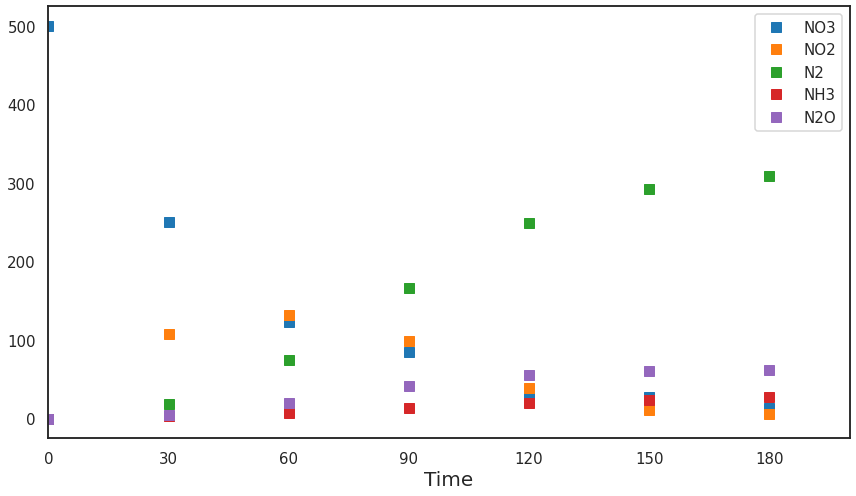

In [3]:
tickparams = {'fontsize':15, 'xticks':catalysis_data.Time.values}
markerparams = {'marker':'s', 'markersize':10}
ax=catalysis_data.plot(style='s', x=0, figsize=(12, 7), xlim=(0, 200),
                       **tickparams, 
                       **markerparams)
ax.set_xlabel('Time', fontsize=20)
ax.legend(loc='best', fontsize=15)
plt.tight_layout()

The observed data is the flattened vector of concentrations of each of the reactants and products at $t=20, 60, 90, 120, 150, 180$. We collect the observed data and flatten the data matrix into a vector.

In [0]:
Y = catalysis_data.values
data = Y[1:, 1:].flatten()
# print(Y.flatten(order='F'))
#print(data)
Y=data
#Y.flatten()

We also require the model (i.e. solver) for the dynamical system governing the catalytic conversion. 

In [0]:
import scipy.integrate 

def A(x):
    k = np.exp(x) / 180.
    res = np.zeros((6,6))
    res[0, 0] = -k[0]
    res[1, 0] = k[0]
    res[1, 1] = -(k[1] + k[3] + k[4]) 
    res[2, 1] = k[1]
    res[2, 2] = -k[2] 
    res[3, 2] = k[2] 
    res[4, 1] = k[4] 
    res[5, 1] = k[3] 
    return res

def g(z, t, x):
    return np.dot(A(x), z)

def Z(x, t):
    z0 = np.array([500., 0., 0., 0., 0., 0.])
    return scipy.integrate.odeint(g, z0, t, args=(x,))[1:]

T = np.linspace(0, 180, 7)

Notice that we are working with the transformed variable `x` which is converted into the reaction rate vector `k` inside the solver. 

Suppose we have the following Gaussian prior for the reaction rates:
$$
p(\mathbf{x}) = \mathcal{N}(\mathbf{x}|\mathbf{0}, \gamma^2 \mathbf{I}),
$$
and the measurement process is defined by the following likelihood model:
$$
p(y|\mathbf{x}, \sigma^2, \gamma) = \mathcal{N}(y|f(\mathbf{x}), \sigma^2),
$$
where, $f(\cdot)$ denotes the dynamical system model. 
The likelihood specification encodes the assumption that observations (i.e. concentrations of all substances at all observation times) are independent of each other and individually follow a Gaussian distribution with fixed variance. 

The likelihood mean $f(\cdot)$ has already been implemented for you as the `CatalyticSolver` function. 

### Part A -  Constant $\gamma$ and $\sigma$

Fix the prior precision parameter $\gamma$ and the likelihood noise $\sigma$ as constants and use `PyMC3` to estimate the posterior distribution over the transformed reaction rates vector $x$ and use the posterior distribution to show the predictive distribution of reactact/product concentrations as a function of time.  

Here is the workflow you should follow:

1. Express the model using suitable distributions for the priors and the likelihood with a `pymc3.model` context.

2. Simulate a Markov Chain to generate samples of $x$ (you just need to call `pymc3.sample` with appropriate arguments). 

3. Perform model diagnostics, i.e., tune the hyperparameters, $\gamma$ and $\sigma$, burn early samples of the chain to remove transient phase samples, and thin the MC to remove autocorrelation.

4. Plot the posterior predictive distribution of the reactant/product concentrations.

**Solution:**
<br></br>
The posterior distribution we wish to sample from is given by:
$$
\pi(X)=p(x|y,\sigma^2) \propto p(y|x,\sigma^2)p(x)=\mathcal{N}(y|f(\mathbf{x}), \sigma^2)\mathcal{N}(\mathbf{x}|\mathbf{0}, \gamma^2 \mathbf{I}) \propto exp \left( \frac{||y-f(x)||^2_2}{2\sigma^2}-\frac{||x||^2_2}{2\gamma^2} \right)
$$
<br></br>

In [0]:
def make_model_1(gamma, sigma):
    Yobs = Y.flatten()
    # Yobs = Y

    invgamma2 = gamma ** -2
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))

    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()

    invsigma2 = sigma ** -2
    observation = pm.Normal("obs", mu=fm, tau=invsigma2, value=Yobs, observed=True)
    return locals()

In [0]:
gamma = 1.5
sigma = 12.
nsample=50000
Model1 = pm.MCMC(make_model_1(gamma, sigma)); 
Model1.sample(nsample, burn= 10000, thin=10); 
samples1= Model1.trace('x')[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 76.4 sec

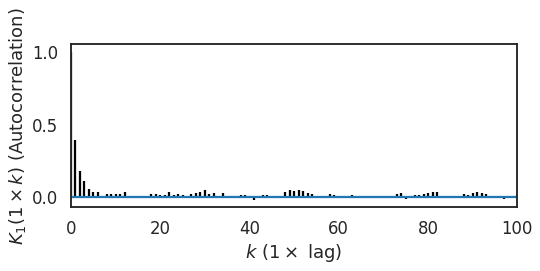

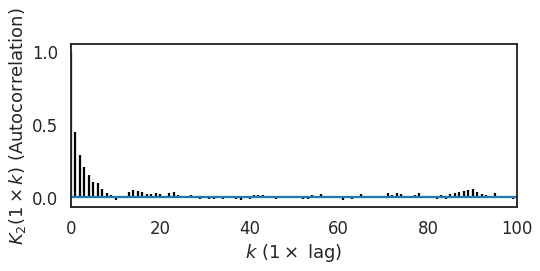

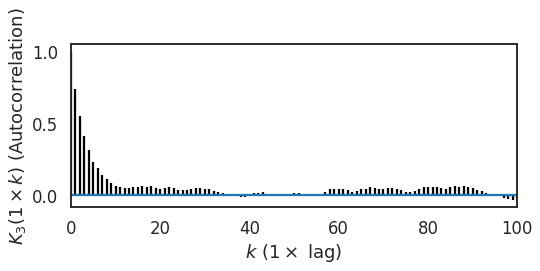

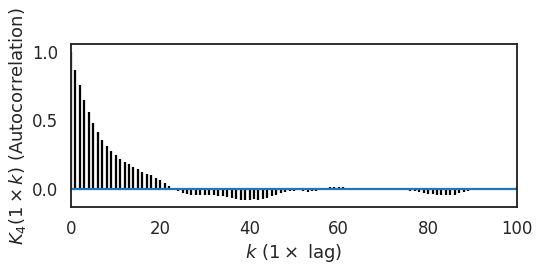

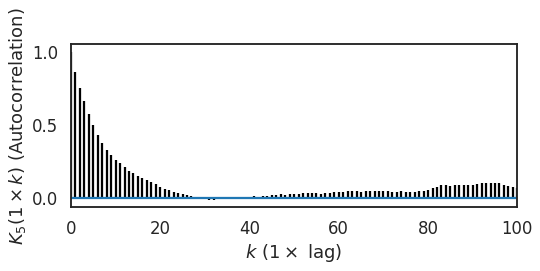

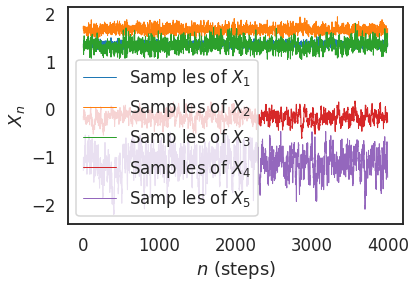

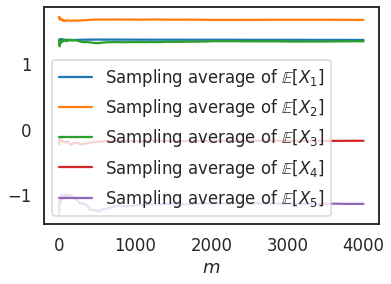

In [0]:
burn = 0
thin = 1
samples_rest_1 = samples1[burn::thin] 

for i in range(samples_rest_1.shape[1]):
    fig, ax = plt.subplots(figsize= [8,3])
    ax.acorr(samples_rest_1[:, i], detrend=plt.mlab.detrend_mean, maxlags=100) 
    ax.set_xlim(0, 100)
    ax.set_ylabel(r'$K_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin)) 
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

fig, ax = plt.subplots()
for i in range(samples_rest_1.shape[1]):
    ax.plot(range(samples_rest_1.shape[0]), samples_rest_1[:,i], lw=1 , label='Samp les of $X_{%d}$' % (i+1))
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
plt.legend(loc='best')

fig, ax = plt.subplots()
idx = np.arange(1, samples_rest_1.shape[0] + 1) 
for i in range(samples_rest_1.shape[1]):
    X_ave = np.transpose([np.cumsum(samples_rest_1[:,i]) / idx ])
    ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_{%d}]$' % (i+1)) 
plt.legend(loc='best')
ax.set_xlabel('$m$');

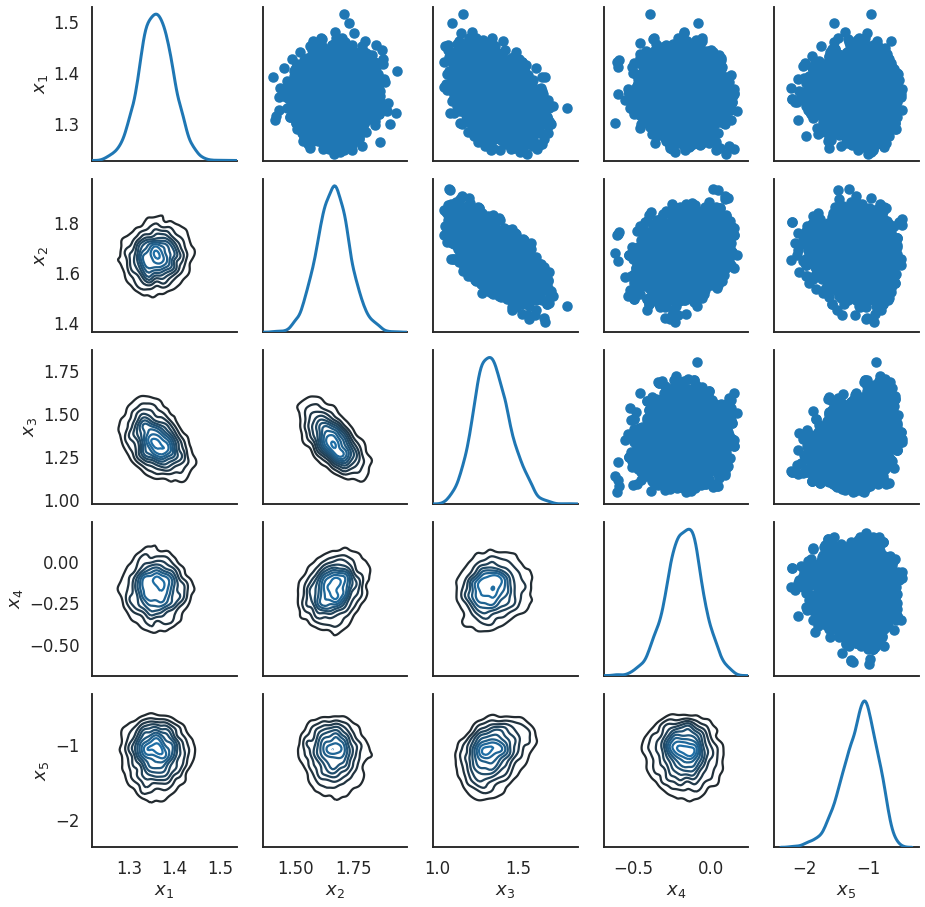

In [0]:
df = pd.DataFrame(samples_rest_1, columns=['$x_{%d}$' % (i + 1) for i in range(samples_rest_1.shape[1])])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter) 
gg.map_diag(sns.kdeplot, lw=3);

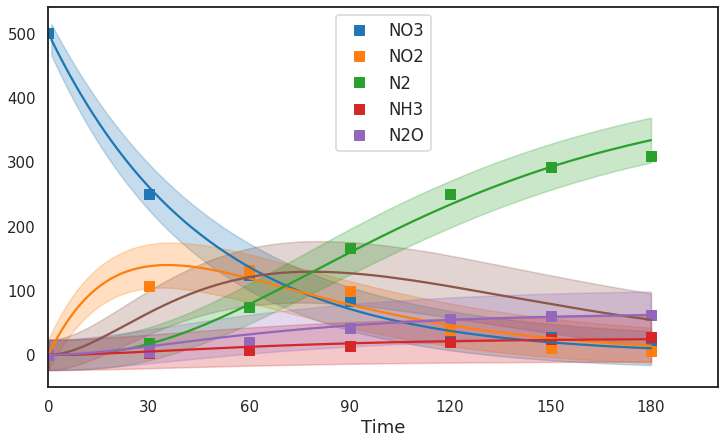

In [0]:
t = np.linspace(0, 180, 200)
Y_rest = np.ndarray((samples_rest_1.shape[0], 200, 6)) 
for i in range(samples_rest_1.shape[0]):
    Y_rest[i, 1:, :] = Z(samples_rest_1[i, :], t)
Y_median = np.median(Y_rest, axis=0)
Y_lower = np.percentile(Y_rest, 2.5, axis=0) - 1.96 * sigma 
Y_upper = np.percentile(Y_rest, 97.5, axis=0) + 1.96 * sigma

# fig, ax = plt.subplots(figsize=(10, 10))
tickparams = {'fontsize':15, 'xticks':catalysis_data.Time.values}
markerparams = {'marker':'s', 'markersize':10}
ax=catalysis_data.plot(style='s', x=0, figsize=(12, 7), xlim=(0, 200),
                       **tickparams, 
                       **markerparams)
# ax.plot(catalysis_data, style='s')
# catalysis_data.plot(ax=ax, style='s')

ax.plot(t[1:], Y_median[1:, 0], color=sns.color_palette()[0], label='Model NO3-') 
ax.plot(t, Y_median[:, 1], color=sns.color_palette()[1], label='Model NO2-') 
ax.plot(t, Y_median[:, 2], color=sns.color_palette()[5], label='Model X') 
ax.plot(t, Y_median[:, 3], color=sns.color_palette()[2], label='Model N2') 
ax.plot(t, Y_median[:, 4], color=sns.color_palette()[3], label='Model NH3') 
ax.plot(t, Y_median[:, 5], color=sns.color_palette()[4], label='Model N2O') 
ax.fill_between(t[1:], Y_lower[1:, 0], Y_upper[1:, 0], color=sns.color_palette()[0] , alpha=0.25)
ax.fill_between(t, Y_lower[:, 1], Y_upper[:, 1], color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(t, Y_lower[:, 2], Y_upper[:, 2], color=sns.color_palette()[5], alpha=0.25)
ax.fill_between(t, Y_lower[:, 3], Y_upper[:, 3], color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(t, Y_lower[:, 4], Y_upper[:, 4], color=sns.color_palette()[3], alpha=0.25)
ax.fill_between(t, Y_lower[:, 5], Y_upper[:, 5], color=sns.color_palette()[4], alpha=0.25);

### Part B -  Exponential prior over $\sigma^2$ and $\gamma^2$

We will now introduce prior specifications for $\sigma^2$ and $\gamma^2$. Let $p(\sigma^2) = \mathrm{Exp}(\sigma^2 | \alpha_1)$ and $p(\gamma^2) = \mathrm{Exp}(\gamma^2 | \alpha_2)$, where, $\mathrm{Exp}$ denotes the exponential distribution. This formulation introduces 2 additional parameters to tune - $\alpha_1$ and $\alpha_2$. 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

In [0]:
def make_model_2(alpha1, alpha2):
    Yobs = Y.flatten()
    
    gamma2 = pm.Exponential('gamma^2', alpha1)
    sigma2 = pm.Exponential('sigma^2', alpha2)
    invgamma2 = gamma2 ** -1
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))
    
    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()

    invsigma2 = sigma2 ** -1
    observation = pm.Normal("obs", mu=fm, tau=invsigma2, value=Yobs, observed=True)
    
    return locals()

In [0]:
alpha1 = .8
alpha2 = .2
nsample=50000
Model2 = pm.MCMC(make_model_2(alpha1, alpha2)); 
Model2.sample(nsample, burn= 5000, thin=25); 
samples2= Model2.trace('x')[:] 
samples2_gamma=Model2.trace('gamma^2')[:] 
samples2_sigma=Model2.trace('sigma^2')[:]

 [-----------------100%-----------------] 50000 of 50000 complete in 80.8 sec

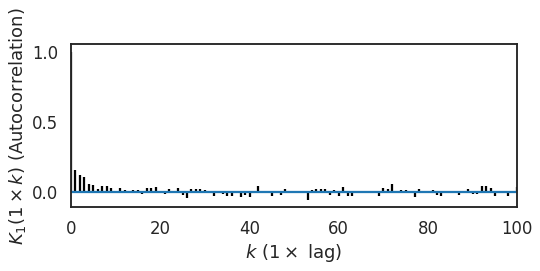

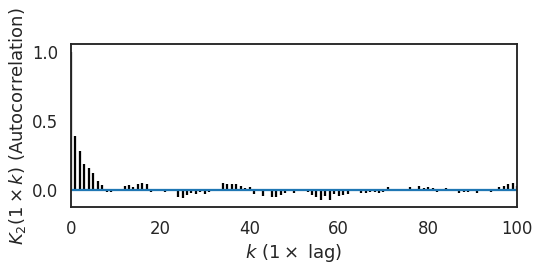

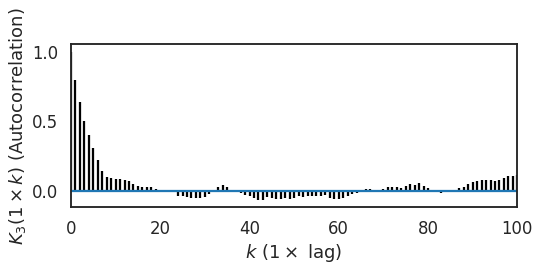

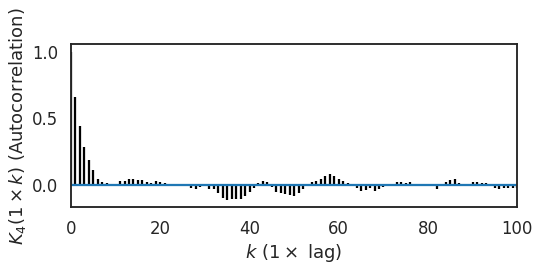

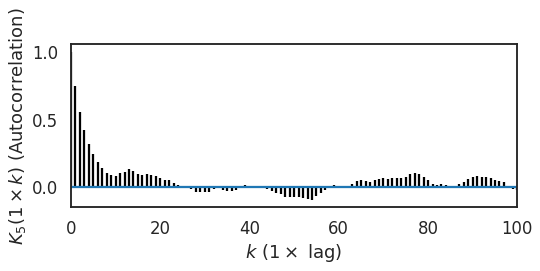

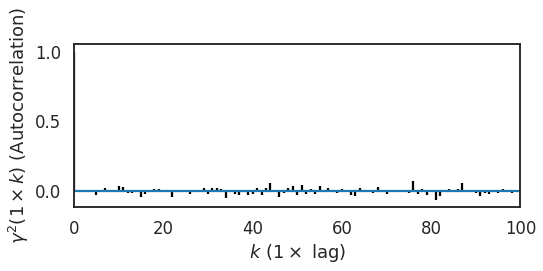

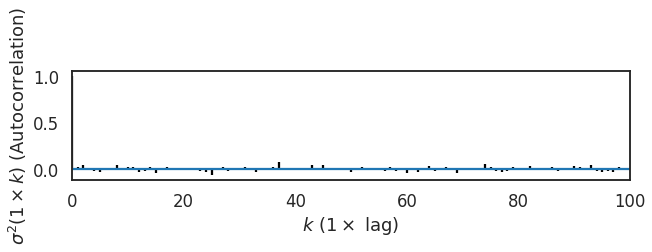

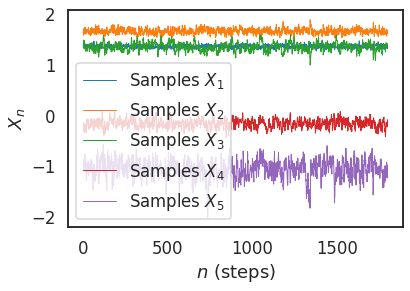

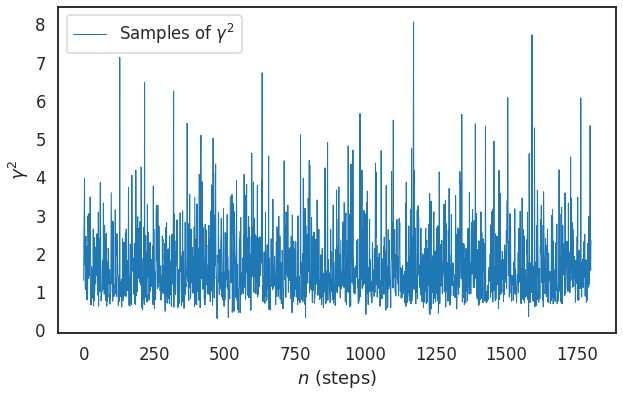

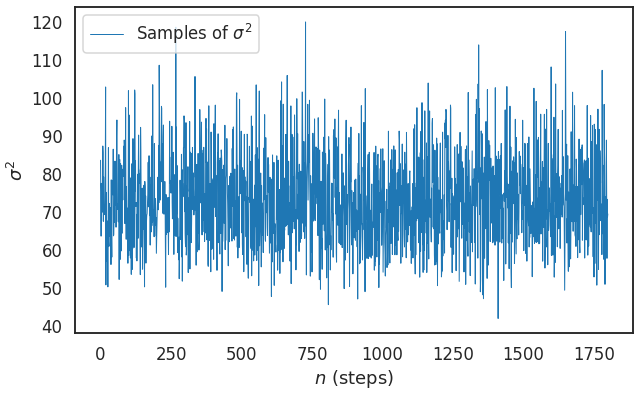

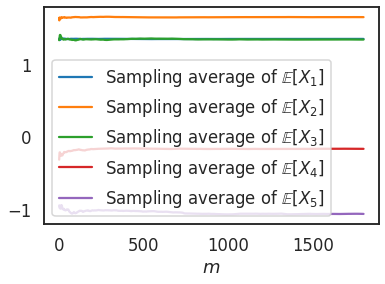

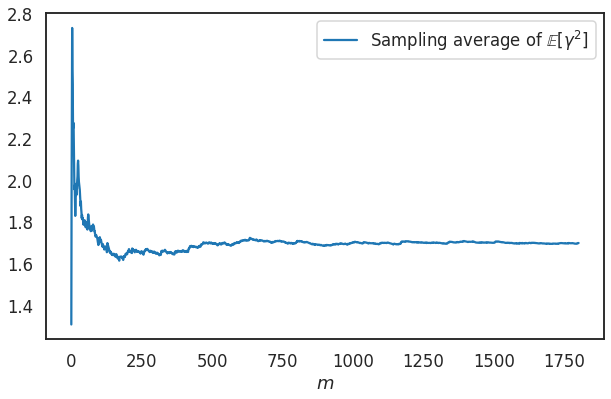

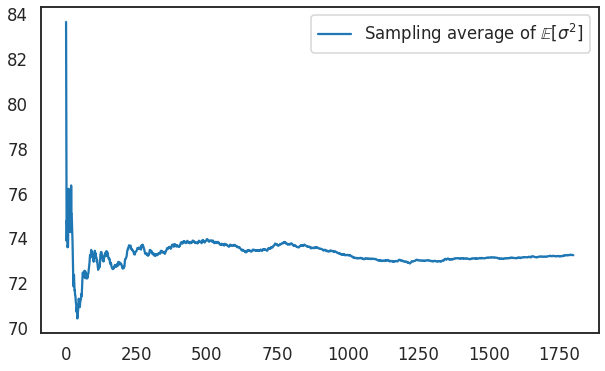

In [0]:
burn = 0
thin = 1
samples_rest_2 = samples2[burn::thin] 

for i in range(samples_rest_2.shape[1]):
    fig, ax = plt.subplots(figsize= [8,3])
    ax.acorr(samples_rest_2[:, i], detrend=plt.mlab.detrend_mean, maxlags=100) 
    ax.set_xlim(0, 100)
    ax.set_ylabel(r'$K_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin)) 
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

samples_rest_2_gamma = samples2_gamma[burn::thin];
fig, ax = plt.subplots(figsize= [8,3])
ax.acorr(samples_rest_2_gamma, detrend=plt.mlab.detrend_mean, maxlags=100) ; 
ax.set_ylabel(r'$\gamma^2(%d \times k)$ (Autocorrelation)' % ( thin)) 
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);
ax.set_xlim(0, 100)

samples_rest_2_sigma = samples2_sigma[burn::thin];
fig, ax = plt.subplots(figsize= [10,2])
ax.acorr(samples_rest_2_sigma, detrend=plt.mlab.detrend_mean, maxlags=100) ; 
ax.set_ylabel(r'$\sigma^2(%d \times k)$ (Autocorrelation)' % ( thin)) 
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);
ax.set_xlim(0, 100)

fig, ax = plt.subplots()
for i in range(samples_rest_2.shape[1]):
    ax.plot(range(samples_rest_2.shape[0]), samples_rest_2[:,i], lw=1 , label='Samples $X_{%d}$' % (i+1))
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=[10,6]) 
ax.plot(range(samples_rest_2_gamma.shape[0]), samples_rest_2_gamma, lw=1 , label='Samples of $\gamma^2 $')
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2$')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=[10,6]) 
ax.plot(range(samples_rest_2_sigma.shape[0]), samples_rest_2_sigma, lw=1 , label='Samples of $\sigma^2 $')
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\sigma^2$')
plt.legend(loc='best')

fig, ax = plt.subplots()
idx = np.arange(1, samples_rest_2.shape[0] + 1) 
for i in range(samples_rest_2.shape[1]):
    X_ave = np.transpose([np.cumsum(samples_rest_2[:,i]) / idx ])
    ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_{%d}]$' % (i+1)) 
plt.legend(loc='best')
ax.set_xlabel('$m$');

fig, ax = plt.subplots(figsize=[10,6])
X_ave = np.transpose([np.cumsum(samples_rest_2_gamma) / idx ]) 
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[\gamma^2]$') 
plt.legend(loc='best')
ax.set_xlabel('$m$');

fig, ax = plt.subplots(figsize=[10,6])
X_ave = np.transpose([np.cumsum(samples_rest_2_sigma) / idx ]) 
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[\sigma^2]$') 
plt.legend(loc='best')

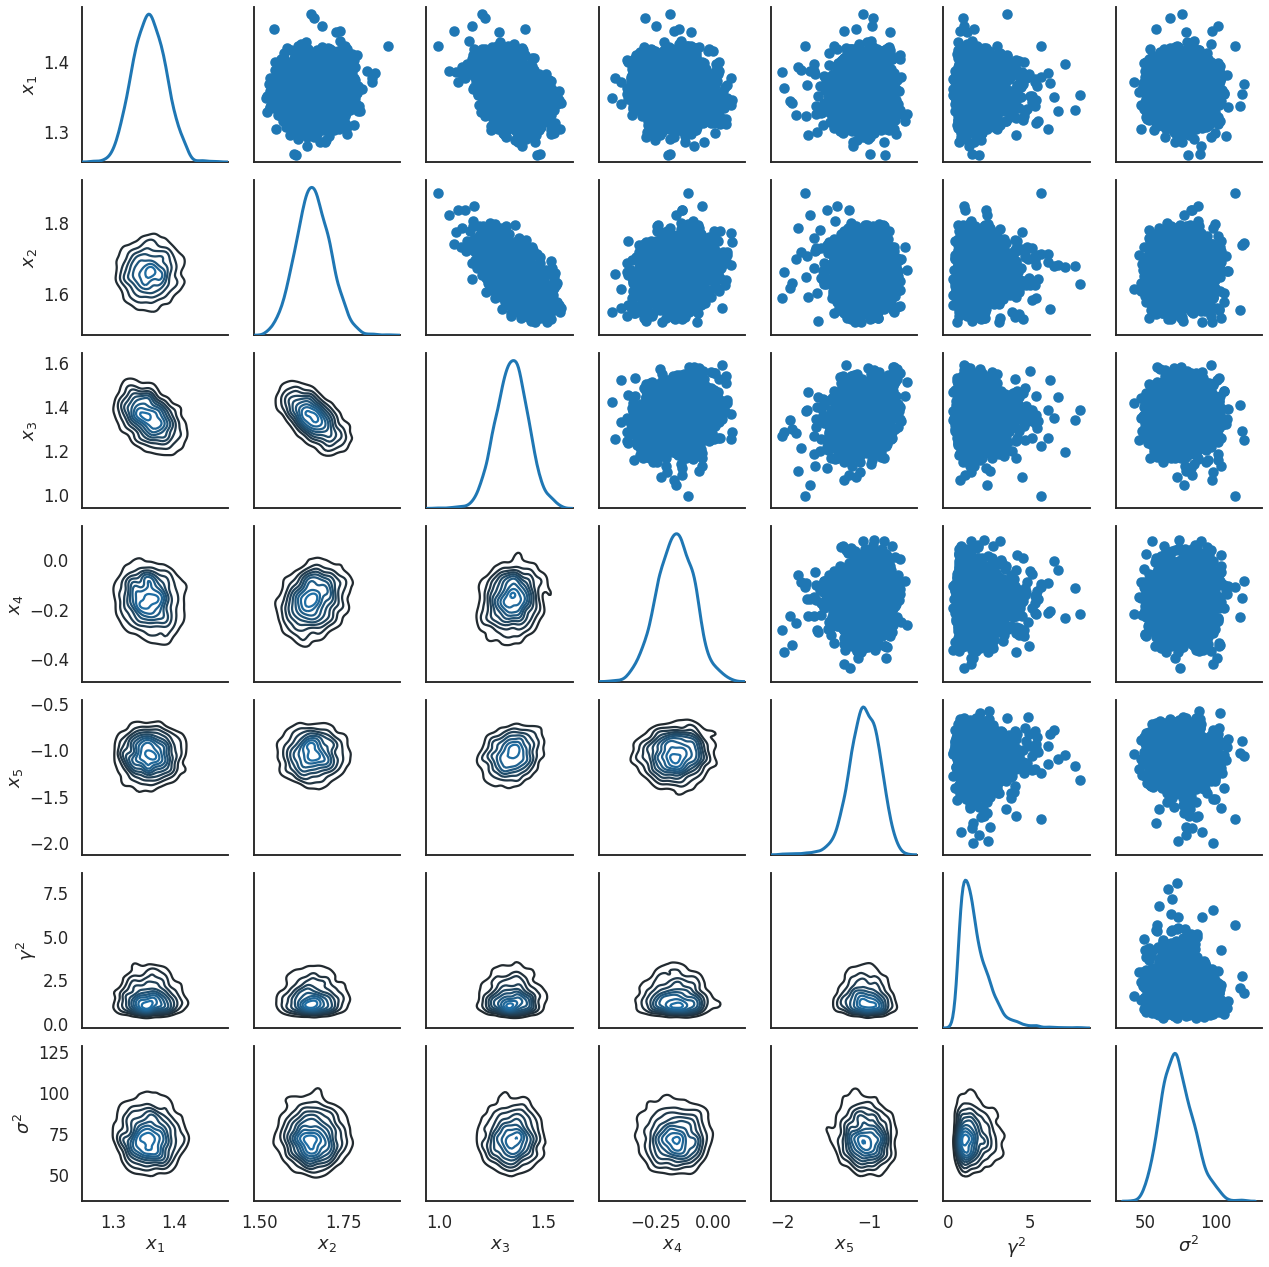

In [0]:
df = pd.DataFrame(samples_rest_2,columns=['$x_{%d}$' % (i + 1) for i in range(samples_rest_2.shape[1])]) 
df['$\gamma^2$']=pd.Series(samples_rest_2_gamma ) 
df['$\sigma^2$']=pd.Series(samples_rest_2_sigma ) 
gg = sns.PairGrid(df, diag_sharey=False) 
gg.map_lower(sns.kdeplot) 
gg.map_upper(plt.scatter) 
gg.map_diag(sns.kdeplot, lw=3);

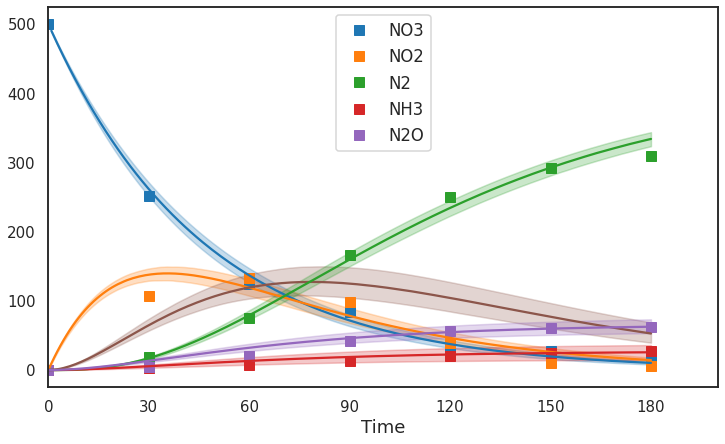

In [0]:
t = np.linspace(0, 180, 200)
Y_rest = np.ndarray((samples_rest_2.shape[0], 200, 6)) 
for i in range(samples_rest_2.shape[0]):
    Y_rest[i, 1:, :] = Z(samples_rest_2[i, :], t) 
Y_median = np.median(Y_rest, axis=0)
Y_lower = np.percentile(Y_rest, 1, axis=0) 
Y_upper = np.percentile(Y_rest, 99, axis=0)
# fig, ax = plt.subplots(figsize=(10, 10))
# catalysis_data.plot(ax=ax, style='s')
tickparams = {'fontsize':15, 'xticks':catalysis_data.Time.values}
markerparams = {'marker':'s', 'markersize':10}
ax=catalysis_data.plot(style='s', x=0, figsize=(12, 7), xlim=(0, 200),
                       **tickparams, 
                       **markerparams)
ax.plot(t[1:], Y_median[1:, 0], color=sns.color_palette()[0], label='Model NO3-') 
ax.plot(t, Y_median[:, 1], color=sns.color_palette()[1], label='Model NO2-') 
ax.plot(t, Y_median[:, 2], color=sns.color_palette()[5], label='Model X') 
ax.plot(t, Y_median[:, 3], color=sns.color_palette()[2], label='Model N2') 
ax.plot(t, Y_median[:, 4], color=sns.color_palette()[3], label='Model NH3') 
ax.plot(t, Y_median[:, 5], color=sns.color_palette()[4], label='Model N2O') 
ax.fill_between(t[1:], Y_lower[1:, 0], Y_upper[1:, 0], color=sns.color_palette()[0] , alpha=0.25)
ax.fill_between(t, Y_lower[:, 1], Y_upper[:, 1], color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(t, Y_lower[:, 2], Y_upper[:, 2], color=sns.color_palette()[5], alpha=0.25)
ax.fill_between(t, Y_lower[:, 3], Y_upper[:, 3], color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(t, Y_lower[:, 4], Y_upper[:, 4], color=sns.color_palette()[3], alpha=0.25)
ax.fill_between(t, Y_lower[:, 5], Y_upper[:, 5], color=sns.color_palette()[4], alpha=0.25);

### Part C - A model with a different noise variance for each observed species with Jeffrey's prior.

We will now consider the following likelihood:
$$
p(y_i|\mathbf{x}) = \mathcal{N}(y_i|f(\mathbf{x}), \sigma_{i}^{2}),
$$
where $i$ is an index for observed chemical species.  In other words, we construct the likelihood model such that there is a different noise parameter, $\sigma_i$ associated with the measurements obtained for each different species. 
Each $\sigma_{i}^{2}$ is specified with a Jeffreys' prior, i.e., $p(\sigma_{i}^{2}) \propto \frac{1}{\sigma_{i}^{2}}$.

**Solution:**
<br>
We first put Jeffrey's prior over $\sigma^2$ and $\gamma^2$, and then answer this part:
$$
p(\sigma^2) \propto \frac{1}{\sigma^2}
$$
$$
p(\gamma^2) \propto \frac{1}{\gamma^2}
$$
</br>

In [0]:
def make_model_3():
    Yobs = Y.flatten()

    @pm.stochastic(observed=False) 
    def jefsigma2(value=10):
        if value <= 0: 
          return -np.Inf
        return -2 * np.log(value)

    @pm.stochastic(observed=False) 
    def jefgamma2(value=10):
        if value <= 0: 
          return -np.Inf
        return -2 * np.log(value)

    invgamma2 = jefgamma2 ** -1
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))

    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()

    invsigma2 = jefsigma2 ** -1
    observation = pm.Normal("obs", mu=fm, tau=invsigma2, value=Yobs, observed=True)
    return locals()

In [7]:
nsample=200000
Model_3 = pm.MCMC(make_model_3()); 
Model_3.sample(nsample, burn= 10000, thin=10); 
samples3= Model_3.trace('x')[:] 
samples3_gamma=Model_3.trace('jefgamma2')[:] 
samples3_sigma=Model_3.trace('jefsigma2')[:]

 [-----------------100%-----------------] 200000 of 200000 complete in 322.2 sec

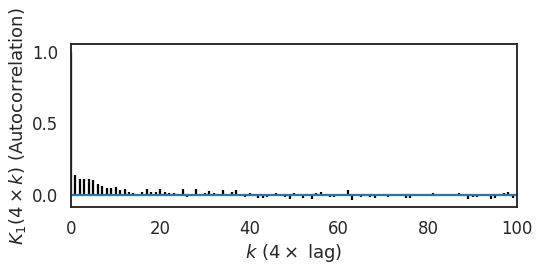

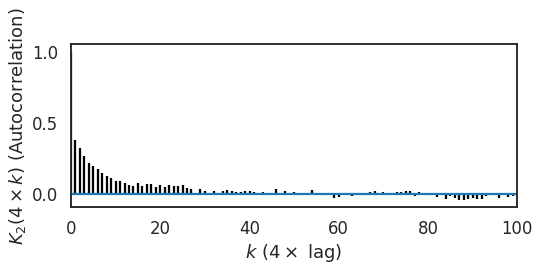

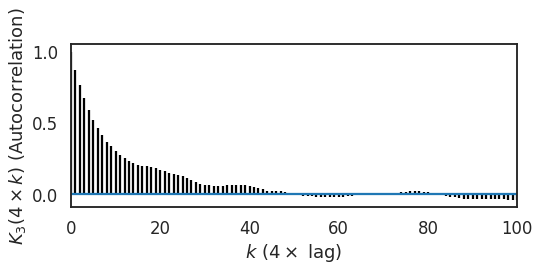

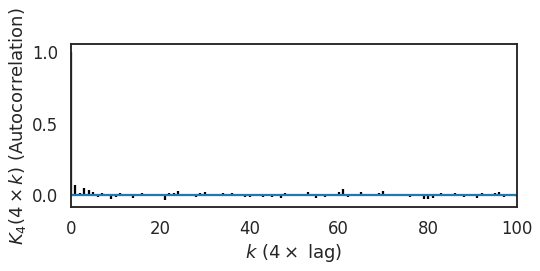

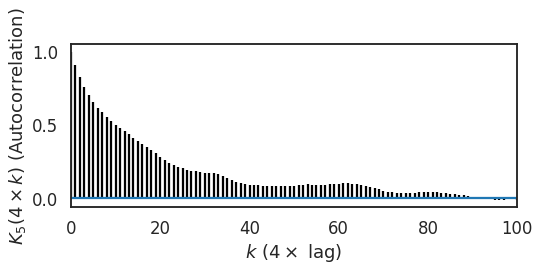

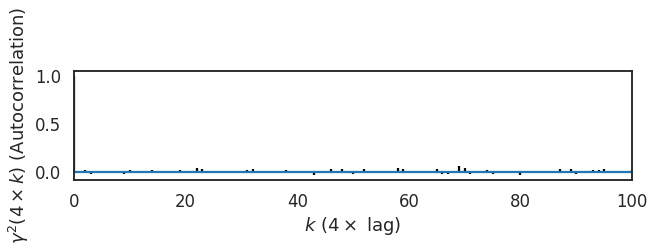

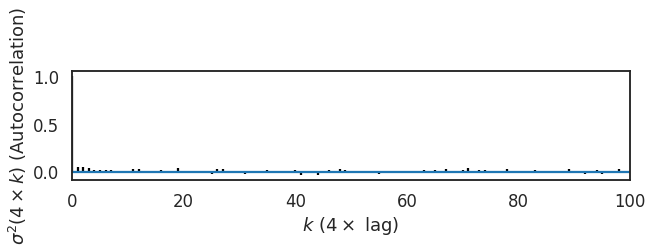

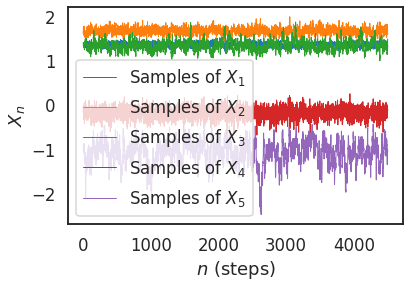

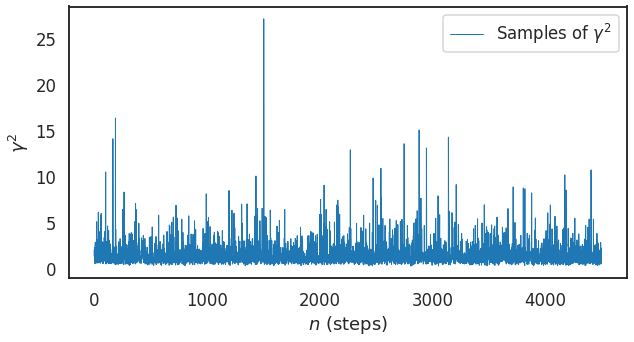

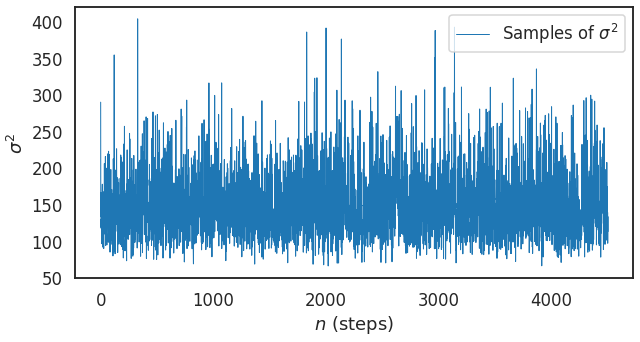

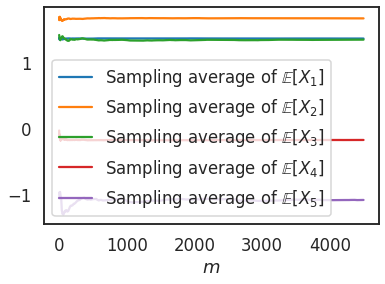

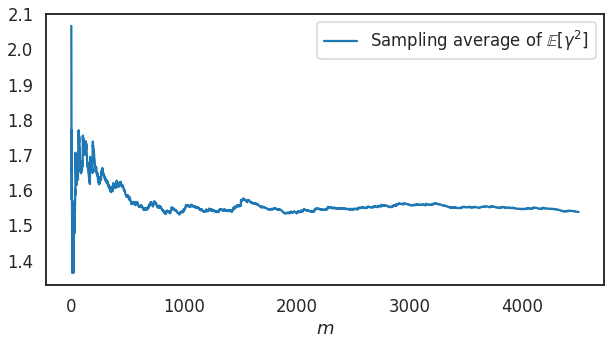

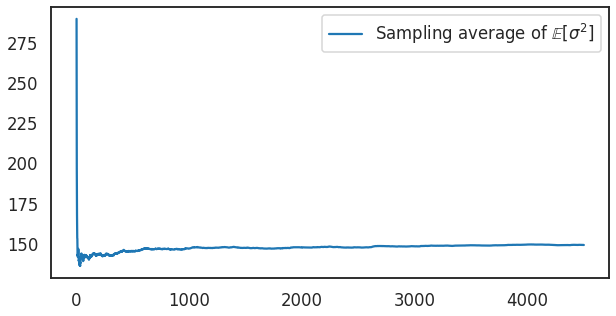

In [8]:
burn = 1000
thin = 4

samples_rest_3 = samples3[burn::thin] 
for i in range(samples_rest_3.shape[1]):
    fig, ax = plt.subplots(figsize= [8,3])
    ax.acorr(samples_rest_3[:, i], detrend=plt.mlab.detrend_mean, maxlags=100) 
    ax.set_xlim(0, 100)
    ax.set_ylabel(r'$K_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin)) 
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

samples_rest_3_gamma = samples3_gamma[burn::thin];
fig, ax = plt.subplots(figsize= [10,2])
ax.acorr(samples_rest_3_gamma, detrend=plt.mlab.detrend_mean, maxlags=100) ; 
ax.set_ylabel(r'$\gamma^2(%d \times k)$ (Autocorrelation)' % ( thin)) 
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);
ax.set_xlim(0, 100)

samples_rest_3_sigma = samples3_sigma[burn::thin];
fig, ax = plt.subplots(figsize= [10,2])
ax.acorr(samples_rest_3_sigma, detrend=plt.mlab.detrend_mean, maxlags=100) ; 
ax.set_ylabel(r'$\sigma^2(%d \times k)$ (Autocorrelation)' % ( thin)) 
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);
ax.set_xlim(0, 100)

fig, ax = plt.subplots()
for i in range(samples_rest_3.shape[1]):
    ax.plot(range(samples_rest_3.shape[0]), samples_rest_3[:,i], lw=1 , label='Samples of $X_{%d}$' % (i+1))
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=[10,5]) 
ax.plot(range(samples_rest_3_gamma.shape[0]), samples_rest_3_gamma, lw=1 , label='Samples of $\gamma^2 $')
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2$')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=[10,5]) 
ax.plot(range(samples_rest_3_sigma.shape[0]), samples_rest_3_sigma, lw=1 , label='Samples of $\sigma^2 $')
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\sigma^2$')
plt.legend(loc='best')

fig, ax = plt.subplots()
idx = np.arange(1, samples_rest_3.shape[0] + 1) 
for i in range(samples_rest_3.shape[1]):
    X_ave = np.transpose([np.cumsum(samples_rest_3[:,i]) / idx ])
    ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_{%d}]$' % (i+1)) 
plt.legend(loc='best')
ax.set_xlabel('$m$');

fig, ax = plt.subplots(figsize=[10,5])
X_ave = np.transpose([np.cumsum(samples_rest_3_gamma) / idx ]) 
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[\gamma^2]$') 
plt.legend(loc='best')
ax.set_xlabel('$m$');

fig, ax = plt.subplots(figsize=[10,5])
X_ave = np.transpose([np.cumsum(samples_rest_3_sigma) / idx ]) 
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[\sigma^2]$') 
plt.legend(loc='best')

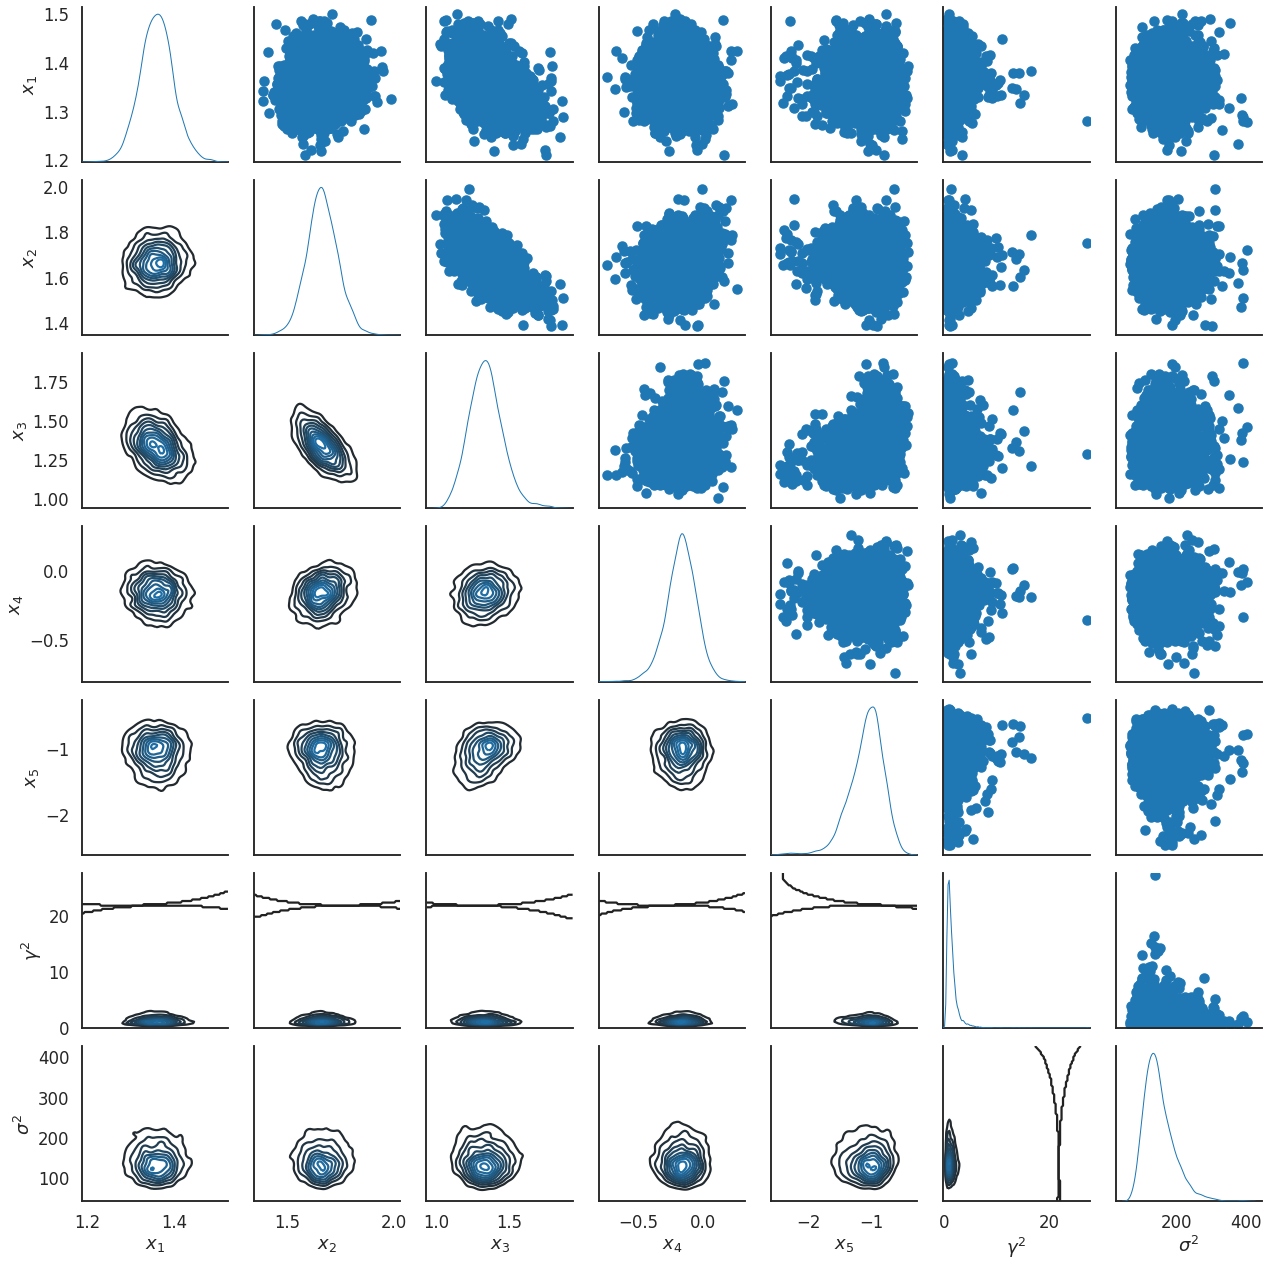

In [9]:
df = pd.DataFrame(samples_rest_3,columns=['$x_{%d}$' % (i + 1) for i in range(samples_rest_3.shape[1])]) 
df['$\gamma^2$']=pd.Series(samples_rest_3_gamma ) 
df['$\sigma^2$']=pd.Series(samples_rest_3_sigma ) 
gg = sns.PairGrid(df, diag_sharey=False) 
gg.map_lower(sns.kdeplot) 
gg.map_upper(plt.scatter) 
gg.map_diag(sns.kdeplot, lw=1);

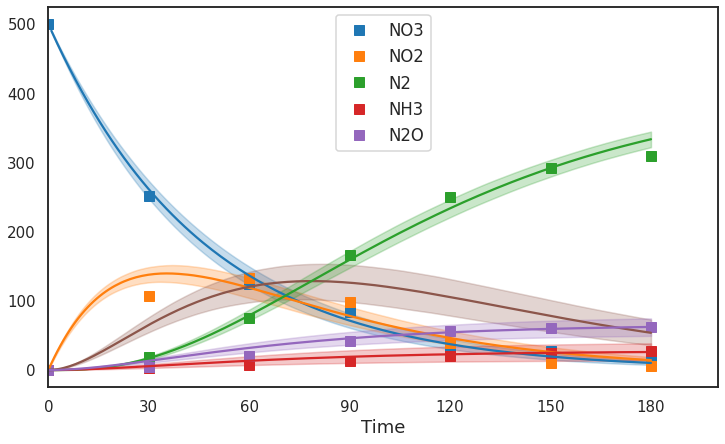

In [10]:
t = np.linspace(0, 180, 200)
Y_rest = np.ndarray((samples_rest_3.shape[0], 200, 6)) 

for i in range(samples_rest_3.shape[0]):
    Y_rest[i, 1:, :] = Z(samples_rest_3[i, :], t) 
Y_median = np.median(Y_rest, axis=0)
Y_lower = np.percentile(Y_rest, 2.5, axis=0) 
Y_upper = np.percentile(Y_rest, 97.5, axis=0)

# fig, ax = plt.subplots(figsize=(10, 10))
# catalysis_data.plot(ax=ax, style='s')
tickparams = {'fontsize':15, 'xticks':catalysis_data.Time.values}
markerparams = {'marker':'s', 'markersize':10}
ax=catalysis_data.plot(style='s', x=0, figsize=(12, 7), xlim=(0, 200),
                       **tickparams, 
                       **markerparams)

ax.plot(t[1:], Y_median[1:, 0], color=sns.color_palette()[0], label='Model NO3-') 
ax.plot(t, Y_median[:, 1], color=sns.color_palette()[1], label='Model NO2-') 
ax.plot(t, Y_median[:, 2], color=sns.color_palette()[5], label='Model X') 
ax.plot(t, Y_median[:, 3], color=sns.color_palette()[2], label='Model N2') 
ax.plot(t, Y_median[:, 4], color=sns.color_palette()[3], label='Model NH3') 
ax.plot(t, Y_median[:, 5], color=sns.color_palette()[4], label='Model N2O') 
ax.fill_between(t[1:], Y_lower[1:, 0], Y_upper[1:, 0], color=sns.color_palette()[0] , alpha=0.25)
ax.fill_between(t, Y_lower[:, 1], Y_upper[:, 1], color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(t, Y_lower[:, 2], Y_upper[:, 2], color=sns.color_palette()[5], alpha=0.25)
ax.fill_between(t, Y_lower[:, 3], Y_upper[:, 3], color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(t, Y_lower[:, 4], Y_upper[:, 4], color=sns.color_palette()[3], alpha=0.25)
ax.fill_between(t, Y_lower[:, 5], Y_upper[:, 5], color=sns.color_palette()[4], alpha=0.25);

The main solution to part C is:

In [0]:
def make_model_4():
    Yobs = Y.flatten()

    @pm.stochastic(observed=False) 
    def jefsigma2_1(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_2(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_3(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_4(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_5(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefgamma2(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    invgamma2 = jefgamma2 ** -1
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))
    
    @pm.deterministic 
    def jefsigma2():
        out = np.zeros(30) 
        out[:6] = jefsigma2_1 
        out[6:12] = jefsigma2_2
        out[12:18] = jefsigma2_3
        out[18:24] = jefsigma2_4
        out[24:30] = jefsigma2_5
        return out

    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()
    invsigma2 = jefsigma2 ** -1
    observation = pm.Normal("obs", mu=fm, tau=invsigma2, value=Yobs, observed=True)



    return locals()

In [12]:
nsample=300000
Model_4 = pm.MCMC(make_model_4()); 
Model_4.sample(nsample, burn= 100000, thin=5); 
samples4= Model_4.trace('x')[:] 
samples4_gamma=Model_4.trace('jefgamma2')[:] 
samples4_sigma=Model_4.trace('jefsigma2')[:]

 [-----------------100%-----------------] 300000 of 300000 complete in 506.1 sec

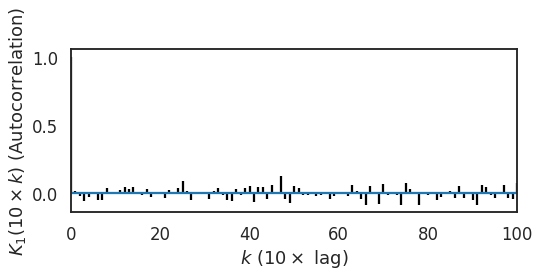

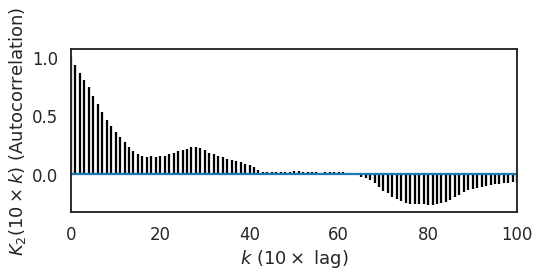

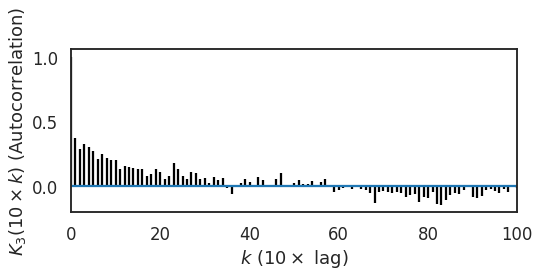

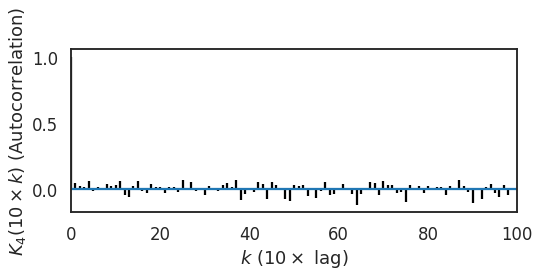

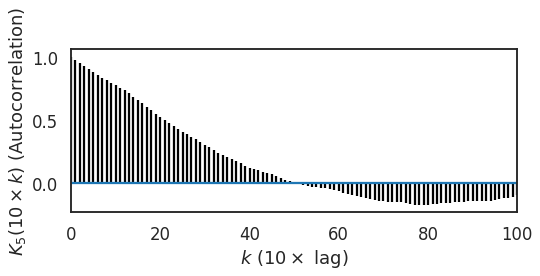

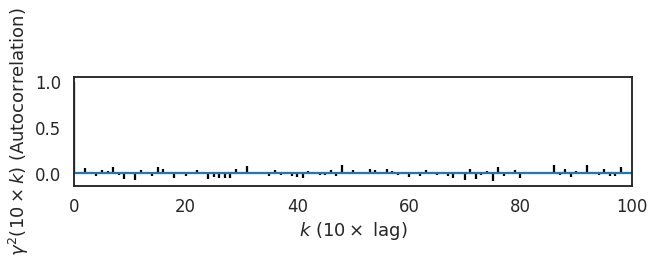

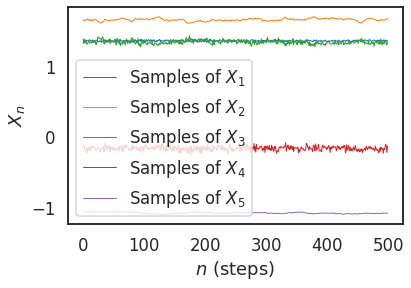

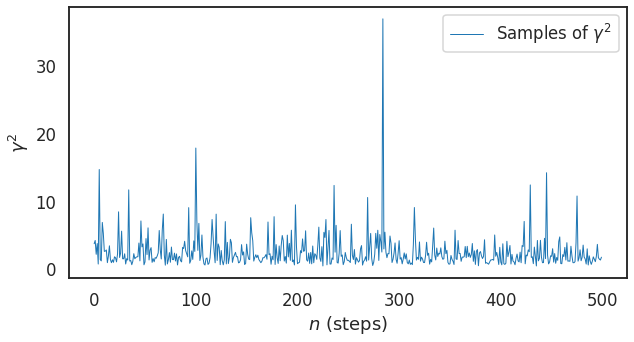

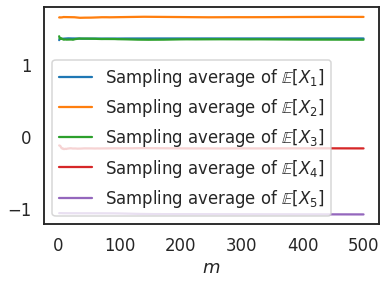

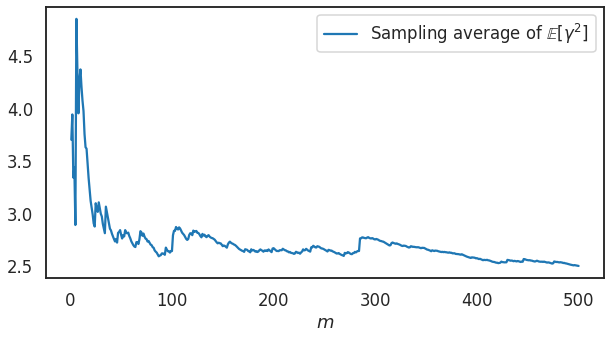

In [13]:
burn = 35000
thin = 10

samples_rest_4 = samples4[burn::thin] 
for i in range(samples_rest_4.shape[1]):
    fig, ax = plt.subplots(figsize= [8,3])
    ax.acorr(samples_rest_4[:, i], detrend=plt.mlab.detrend_mean, maxlags=100) 
    ax.set_xlim(0, 100)
    ax.set_ylabel(r'$K_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin)) 
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

samples_rest_4_gamma = samples4_gamma[burn::thin];
fig, ax = plt.subplots(figsize= [10,2])
ax.acorr(samples_rest_4_gamma, detrend=plt.mlab.detrend_mean, maxlags=100) ; 
ax.set_ylabel(r'$\gamma^2(%d \times k)$ (Autocorrelation)' % ( thin)) 
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);
ax.set_xlim(0, 100)

fig, ax = plt.subplots()
for i in range(samples_rest_4.shape[1]):
    ax.plot(range(samples_rest_4.shape[0]), samples_rest_4[:,i], lw=1 , label='Samples of $X_{%d}$' % (i+1))
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')
plt.legend(loc='best')

fig, ax = plt.subplots(figsize=[10,5]) 
ax.plot(range(samples_rest_4_gamma.shape[0]), samples_rest_4_gamma, lw=1 , label='Samples of $\gamma^2 $')
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2$')
plt.legend(loc='best')

fig, ax = plt.subplots()
idx = np.arange(1, samples_rest_4.shape[0] + 1) 
for i in range(samples_rest_4.shape[1]):
    X_ave = np.transpose([np.cumsum(samples_rest_4[:,i]) / idx ])
    ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_{%d}]$' % (i+1)) 
plt.legend(loc='best')
ax.set_xlabel('$m$');

fig, ax = plt.subplots(figsize=[10,5])
X_ave = np.transpose([np.cumsum(samples_rest_4_gamma) / idx ]) 
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[\gamma^2]$') 
plt.legend(loc='best')
ax.set_xlabel('$m$');

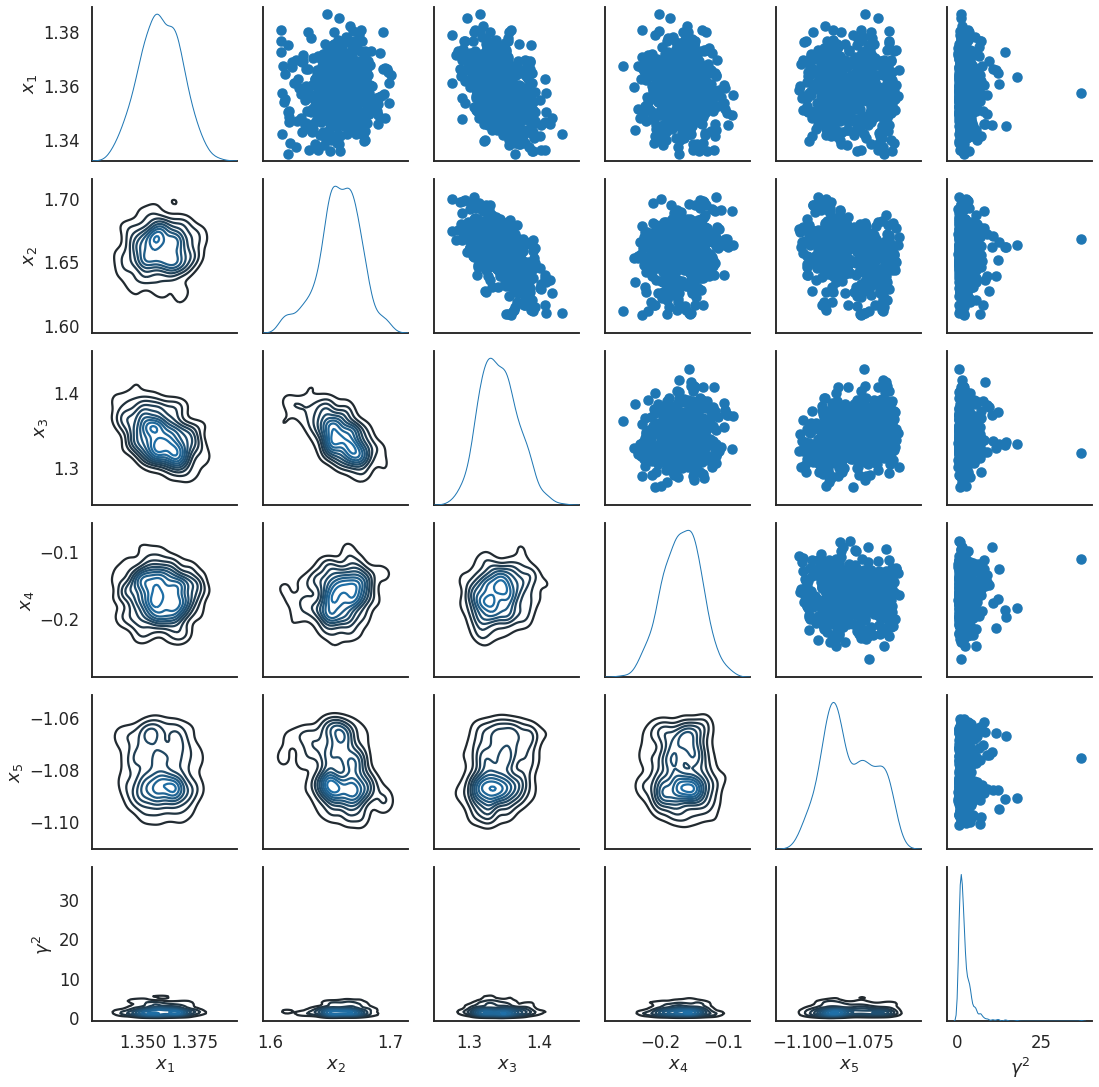

In [14]:
df = pd.DataFrame(samples_rest_4,
                  columns=['$x_{%d}$' % (i + 1) for i in range(samples_rest_4.shape[1])]) 
df['$\gamma^2$']=pd.Series(samples_rest_4_gamma )

gg = sns.PairGrid(df, diag_sharey=False) 
gg.map_lower(sns.kdeplot) 
gg.map_upper(plt.scatter) 
gg.map_diag(sns.kdeplot, lw=1);

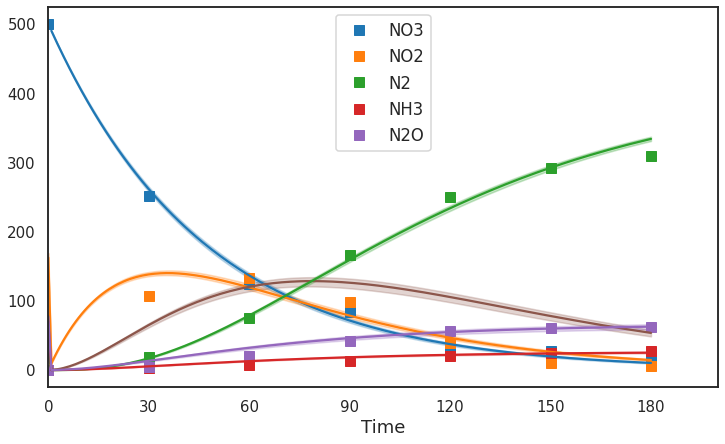

In [15]:
t = np.linspace(0, 180, 200)
Y_rest = np.ndarray((samples_rest_4.shape[0], 200, 6)) 
for i in range(samples_rest_4.shape[0]):
    Y_rest[i, 1:, :] = Z(samples_rest_4[i, :], t) 
Y_median = np.median(Y_rest, axis=0)
Y_lower = np.percentile(Y_rest, 1., axis=0) 
Y_upper = np.percentile(Y_rest, 99., axis=0)

# fig, ax = plt.subplots(figsize=(10, 10))
# catalysis_data.plot(ax=ax, style='s')
tickparams = {'fontsize':15, 'xticks':catalysis_data.Time.values}
markerparams = {'marker':'s', 'markersize':10}
ax=catalysis_data.plot(style='s', x=0, figsize=(12, 7), xlim=(0, 200),
                       **tickparams, 
                       **markerparams)

ax.plot(t[1:], Y_median[1:, 0], color=sns.color_palette()[0], label='Model NO4-') 
ax.plot(t, Y_median[:, 1], color=sns.color_palette()[1], label='Model NO2-') 
ax.plot(t, Y_median[:, 2], color=sns.color_palette()[5], label='Model X') 
ax.plot(t, Y_median[:, 3], color=sns.color_palette()[2], label='Model N2') 
ax.plot(t, Y_median[:, 4], color=sns.color_palette()[3], label='Model NH4') 
ax.plot(t, Y_median[:, 5], color=sns.color_palette()[4], label='Model N2O') 
ax.fill_between(t[1:], Y_lower[1:, 0], Y_upper[1:, 0], color=sns.color_palette()[0] , alpha=0.25)
ax.fill_between(t, Y_lower[:, 1], Y_upper[:, 1], color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(t, Y_lower[:, 2], Y_upper[:, 2], color=sns.color_palette()[5], alpha=0.25)
ax.fill_between(t, Y_lower[:, 3], Y_upper[:, 3], color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(t, Y_lower[:, 4], Y_upper[:, 4], color=sns.color_palette()[3], alpha=0.25)
ax.fill_between(t, Y_lower[:, 5], Y_upper[:, 5], color=sns.color_palette()[4], alpha=0.25);

### Part D - Model Selection using SMC

Use Sequential Monte Carlo (SMC) to determine the model evidence of the 3 different models defined in parts A to C. Which is the best model that you find? 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

In [16]:
!pip install pysmc

  Created wheel for pysmc: filename=PySMC-2.1-cp36-none-any.whl size=25321 sha256=28f151939a4e7860b03d11be0667e69bb0d9c0f384c3a971211d45fdd1d2bf68
  Stored in directory: /root/.cache/pip/wheels/76/12/e8/6f8426dd174f2339c7577d95f9098d3c597a7eb715d79e1ead
Successfully built pysmc


In [0]:
import pysmc as ps
def make_model6_1(gamma_1, sigma_1):
    Yobs = Y.flatten() 
    gamma = 1.

    invgamma2 = gamma_1 ** -2
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))

    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()
    invsigma2 = sigma_1 ** -2

    @pm.stochastic(observed = True)
    def likelihood(value = Yobs,fm =fm , invsigma2=invsigma2, gamma = gamma):
        return gamma * pm.normal_like(value, fm, invsigma2) 
    return locals()

In [0]:
def plot_posterior(smc):
    pa = smc.get_particle_approximation() 
    pa.resample()
    X = pa.x
    fig = plt.figure() 
    fig.subplots_adjust(hspace=0.3, wspace=0.3) 
    for j in xrange(X.shape[1]):
        ax = fig.add_subplot(3, 2, j+1)
        ax.hist(X[:, j], normed=True, alpha=0.5, label='$X_{%d}$' % j, bins = 20) 
        ax.set_xlabel('$X_{%d}$' % (j+1) , fontsize=5)

In [0]:
def fit_smc(model, num_particles=200, verbose=0):
    mcmc = pm.MCMC(model)

    mcmc.use_step_method(ps.RandomWalk, model['x'])
    # mcmc = (model)
    smc = ps.SMC(mcmc, num_particles=num_particles, num_mcmc=10, verbose=verbose, ess_reduction=0.95) 
    smc.initialize(0.) 
    smc.move_to(1.) 
    return smc

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
sigma_1 = 1.5 
gamma_1 = 12
model6_1 = make_model6_1(sigma_1,gamma_1)
smc6_1 = fit_smc(model6_1, num_particles= 200, verbose=1)

# mcmc = pm.MCMC(model6_1)
# smc = ps.SMC(mcmc, num_particles=200, num_mcmc=10, verbose=1, ess_reduction=0.95) 
# smc.initialize(0.) 
# smc.move_to(1.) 
# smc6_1 = smc

------------------------
START SMC Initialization
------------------------
- initializing at gamma : 0.0
- initializing by sampling from the prior: SUCCESS
----------------------
END SMC Initialization
----------------------
-----------------
START SMC MOVE TO
-----------------
initial  gamma : 0.0
final gamma : 1.0
ess reduction:  0.95
- moving to gamma : 0.00021154764264480141
- performing 10 MCMC step(s) per particle
- ESS  = 95.00 %
- logZ = -5.288e-01
 [-----------------89%-------------     ] 1772 of 1990 complete in 2.5 sec
- moving to gamma : 0.00030892639140756326
- performing 10 MCMC step(s) per particle
- ESS  = 90.25 %
- logZ = -2.244e-01
 [-----------------89%--------------    ] 1782 of 1990 complete in 2.6 sec
- moving to gamma : 0.0003897354159074798
- performing 10 MCMC step(s) per particle
- ESS  = 85.74 %
- logZ = -1.802e-01
 [-----------------92%---------------   ] 1842 of 1990 complete in 2.5 sec
- moving to gamma : 0.0004634320564897354
- performing 10 MCMC step(s) 

In [23]:
print (smc6_1.log_Zs)
print ('Log Z SMC 1 estiamte: {0:1.6e}'.format(np.sum(smc6_1.log_Zs)))

[-0.5287589538512458, -0.22438154425467438, -0.180197657733852, -0.1539680967947996, -0.13446722324089322, -0.12150364196867525, -0.11289155593218858, -0.10693480706578917, -0.4439464969015994, -0.20017406111839442, -0.1562856897366105, -0.13251321264924165, -0.12445128877208234, -0.11275711473056127, -0.10106519764148647, -0.0941967604529923, -0.3783071527781461, -0.16339274704114004, -0.1276977681055671, -0.11060170757534937, -0.10625557673560859, -0.10627174461666922, -0.10592695183672429, -0.10647468340634525, -0.35895554846978683, -0.19088222071560246, -0.16546039083940123, -0.17085846369237334, -0.18790724786470214, -0.21135423997081482, -0.21581414552048095, -0.22138785811536543, -0.5058008461863706, -0.3199669987339142, -0.30511805972030714, -0.3630722642931259, -0.31211747275360047, -0.3002977577152057, -0.3177672719412392, -0.4742486895538862, -0.7997433087906556, -0.5452419137955102, -0.4650527123262016, -0.5487181380209822, -0.5378488407106854, -0.572491268923315, -0.546483

In [0]:
def make_model6_2(alpha1, alpha2):
    gamma = 1.
    
    Yobs = Y.flatten()
    
    gamma2 = pm.Exponential('$\gamma^2$', alpha1)
    sigma2 = pm.Exponential('$\sigma^2$', alpha2) 
    invgamma2 = gamma2 ** -1
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))
    
    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()
    
    invsigma2 = sigma2 ** -1
    observation = pm.Normal("obs", mu=fm, tau=invsigma2, value=Yobs, observed=True )
    
    @pm.stochastic(observed = True)
    def likelihood(value = Yobs,fm =fm , invsigma2=invsigma2, gamma = gamma):
        return gamma * pm.normal_like(value, fm, invsigma2) 

    return locals()

In [25]:
alpha1 = .8 
alpha2 = .2
model6_2 = make_model6_2(alpha1,alpha2)
smc6_2 = fit_smc(model6_2, num_particles= 200, verbose=1);

------------------------
START SMC Initialization
------------------------
- initializing at gamma : 0.0
- initializing by sampling from the prior: SUCCESS
----------------------
END SMC Initialization
----------------------
-----------------
START SMC MOVE TO
-----------------
initial  gamma : 0.0
final gamma : 1.0
ess reduction:  0.95
- moving to gamma : 1.1586488905708175e-06
- performing 10 MCMC step(s) per particle
- ESS  = 95.00 %
- logZ = -1.840e-01
 [-----------------95%----------------  ] 1892 of 1990 complete in 2.6 sec
- moving to gamma : 0.00020911843094268426
- performing 10 MCMC step(s) per particle
- ESS  = 90.25 %
- logZ = -1.607e-01
 [-----------------89%--------------    ] 1782 of 1990 complete in 2.5 sec
- moving to gamma : 0.0011835367357887227
- performing 10 MCMC step(s) per particle
- ESS  = 85.74 %
- logZ = -3.289e-01
 [-----------------91%--------------    ] 1822 of 1990 complete in 2.5 sec
- moving to gamma : 0.0028523300257793983
- performing 10 MCMC step(s) 

In [26]:
print (smc6_2.log_Zs)
print ('Log Z SMC 2 estiamte: {0:1.6e}'.format(np.sum(smc6_2.log_Zs)))

[-0.18399272804359157, -0.1607268121350307, -0.3288933170320778, -0.4718420931661491, -0.3853027857967968, -0.3331410714196217, -0.25132562586954865, -0.2493035477161918, -0.9614153427569994, -0.700877818760894, -0.9133465982760054, -1.3271687636855996, -1.7449624575966496, -2.141111255104186, -2.549081820791524, -2.938980328806399, -9.428021087187886, -6.077609571040665, -5.511964863995823, -5.406433662582839, -5.996986553584462, -6.515737350407704, -5.3041836614414315, -5.61945659911108, -17.12934059454872, -10.490899111057555, -9.272092553310063, -9.168605472607418, -8.964802913189756, -0.06193680664256451]
Log Z SMC 2 estiamte: -1.205895e+02


In [0]:
def make_model6_4():
    gamma = 1.
    Yobs = Y.flatten()
    
    @pm.stochastic(observed=False) 
    def jefsigma2_1(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_2(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_3(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_4(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefsigma2_5(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    @pm.stochastic(observed=False) 
    def jefgamma2(value=10):
        if value <= 0: 
            return -np.Inf
        return - np.log(value)
    
    invgamma2 = jefgamma2 ** -1
    x = pm.MvNormal('x', np.zeros(5), invgamma2*np.eye(5))
    
    @pm.deterministic 
    def jefsigma2():
        out = np.zeros(30) 
        out[:6] = jefsigma2_1 
        out[6:12] = jefsigma2_2
        out[12:18] = jefsigma2_3
        out[18:24] = jefsigma2_4
        out[24:30] = jefsigma2_5
        return out
    
    
    @pm.deterministic 
    def fm(x=x):
        tmp = Z(x, T)
        Ym = np.hstack([tmp[:, :2], tmp[:, 3:]]) 
        return Ym.flatten()
    
    invsigma2 = jefsigma2 ** -1
    observation = pm.Normal("obs", mu=fm, tau=invsigma2, value=Yobs, observed=True)

    @pm.stochastic(observed = True)
    def likelihood(value = Yobs,fm =fm , invsigma2=invsigma2, gamma = gamma):
        return gamma * pm.normal_like(value, fm, invsigma2) 
    
    return locals()

In [29]:
model6_4 = make_model6_4()
smc6_4 = fit_smc(model6_4, num_particles= 200, verbose=0)

------------------------
START SMC Initialization
------------------------
- initializing at gamma : 0.0
- initializing by sampling from the prior: SUCCESS
----------------------
END SMC Initialization
----------------------
-----------------
START SMC MOVE TO
-----------------
initial  gamma : 0.0
final gamma : 1.0
ess reduction:  0.95
- moving to gamma : 6.649710535899749e-07
- performing 10 MCMC step(s) per particle
- ESS  = 95.00 %
- logZ = -1.360e-01
 [-----------------94%---------------   ] 1882 of 1990 complete in 2.5 sec
- moving to gamma : 0.00019611063169641018
- performing 10 MCMC step(s) per particle
- ESS  = 90.25 %
- logZ = -1.482e-01
 [-----------------95%----------------  ] 1892 of 1990 complete in 2.6 sec
- moving to gamma : 0.0011855533850382513
- performing 10 MCMC step(s) per particle
- ESS  = 85.74 %
- logZ = -3.575e-01
 [-----------------87%-------------     ] 1742 of 1990 complete in 2.5 sec
- moving to gamma : 0.0025454658897371154
- performing 10 MCMC step(s) p

In [31]:
print (smc6_4.log_Zs)
print ('Log Z SMC 4 estiamte: {0:1.6e}'.format(np.sum(smc6_4.log_Zs)))

[-0.13514317329363124, -3.1119643786081239, -93.067611573491689, -271.3434209537 5632, -371.58746432073167, -236.89397313093653]
Log Z SMC 4 estiamte: -9.761396e+02


In [32]:
print ('Log Z SMC 1 estiamte: {}'.format(np.sum(smc6_1.log_Zs)) )
print ('Log Z SMC 2 estiamte: {}'.format(np.sum(smc6_2.log_Zs)) )
print ('Log Z SMC 4 estiamte: {}'.format(np.sum(smc6_4.log_Zs)) )

Log Z SMC 1 estiamte: -131.62945018822776
Log Z SMC 2 estiamte: -120.4624469792825
Log Z SMC 4 estiamte: -976.1395775312343


These results indicate that the second model has the best performance and is the best choice.

## Problem 2  - Bayesian Linear regression

Recall that the standard Bayesian Linear regression model admits closed form expressions for the posterior distribution over the weights and the posterior predictive distribution over the observations. Suppose you select a vector of suitable basis functions $\phi(x) = (\phi_1(x), \phi_2(x) \dots, \phi_M(x))^T$, the predictive model is the GLM:
$$
f(x) = \mathbf{w}^T \phi(x).
$$

If weights are equipped with a Gaussian prior $p(\mathbf{w}) \sim \mathcal{N}(\mathbf{w}|0, \Sigma_p)$ and the observations are assumed to follow a Gaussian distribution - $\mathbf{y} \sim \mathcal{N}(\mathbf{y} | \Phi \mathbf{w}, \sigma^2 I)$, the posterior distribution over the weights is given by - $p(\mathbf{w} | \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{w} | \mathbf{m}, \mathbf{S})$, where, $\mathbf{S} = (\sigma^{-2} \Phi^T \Phi + \Sigma_p )^{-1}$ and $\mathbf{m} = \sigma^{-2} \mathbf{S} \Phi^T \mathbf{y}$ and the posterior predictive distribution over the observations are given by $p(y^*|x^*, \mathbf{X}, \mathbf{y}) =  \mathcal{N} ( y^* | \mathbf{m}^T \phi(x^*), \phi(x^*)^T \mathbf{S} \phi(x^*) + \sigma^2)$. 

### Part A - Compare MCMC to analytical solution

Setup a GLM for the motorcycle data (loaded below), with an fixed precision prior on the weights and a constant likelihood noise, and use `PyMC3` to determine the posterior over the weights and the posterior predictive distribution at new test inputs. Compare your MCMC solution for the posterior with the analytical solution.

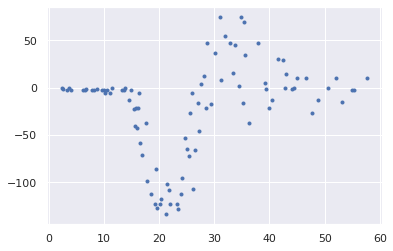

In [0]:
url="https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/lectures/motor.dat"
s=requests.get(url).content
data = np.loadtxt(io.StringIO(s.decode('utf-8')))
#catalysis_data
#data = np.loadtxt("motor.dat")
X = data[:, 0]
y = data[:, 1]
plt.plot(X, y, '.')

In [0]:
import numpy as np
#from autograd import numpy as anp, elementwise_grad as egrad

import theano as th
from theano import shared, function, tensor as tt
import pymc3 as pm

import math
import scipy.stats as st
import scipy

import pandas as pd
import io
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#!pip install import_from_github_com
#from github_com.kennethreitz import requests

#assert requests.get('https://github.com/nvbn/import_from_github_com').status_code == 200
#assert requests.get('https://github.com/PredictiveScienceLab/uq-course/tree/master/lectures').status_code == 200
#!pip install git+https://github.com/PredictiveScienceLab/uq-course/tree/master/lectures.git
#!pip install git+https://github.com/praw-dev/praw.git
#!sudo pip3 install --upgrade git+git://github.com/PredictiveScienceLab/uq-course.git
#from lectures import sample_smc
#!pip install --upgrade git+git://github.com/lynzt/python_people_names.git
import os
#url="https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/lectures/"
#s=requests.get(url)
#os.chdir('s')
#print (os.getcwd())
import urllib
#def import_URL(URL):
#    exec urllib.urlopen(URL).read() in globals()
#import_URL("https://github.com/PredictiveScienceLab/uq-course/tree/master/lectures/sample_smc.py")
#print (s)
#with httpimport.remote_repo(['sample_smc.py'], 'https://github.com/PredictiveScienceLab/uq-course/tree/master/lectures'):
#     import smaple_smc.
#import urllib.request
#a = urllib.request.urlopen("https://github.com/PredictiveScienceLab/uq-course/tree/master/lectures/sample_smc.py")
#eval(a.read())

import numpy as np
import pymc3 as pm
import theano as T
from theano import shared, function, tensor as tt

from google.colab import drive
drive.mount('/content/gdrive')
#os.chdir('/content/gdrive/My Drive/Uncertainty Quantification/sample_smc')
#print (os.getcwd())
%cd /content/gdrive/My\ Drive/Colab Notebooks
from sample_smc import sample_smc

try:
    import sympy
except:
    _=!pip install sympy
    import sympy

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import logging

%matplotlib inline 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [0]:
import numpy as np
!pip install --upgrade pymc3
import pymc3 as pm
import theano as T
from theano import shared, function, tensor as tt
import scipy.linalg

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/Colab Notebooks

from sample_smc import sample_smc 

try:
    import sympy
except:
    _=!pip install sympy
    import sympy

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import logging

%matplotlib inline 

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.8)
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


**Solution:**
<br></br><br></br><br></br><br></br><br></br>

In [0]:
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in range(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])
    

class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in range(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res
    

class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()


class StepFunctionBasis(object):
    """
    A set of step functions.
    
    Arguments:
    X   -  The centers of the step functions.
    """
    def __init__(self, X):
        self.X = X
        self.num_basis = X.shape[0]
    def __call__(self, x):
        res = np.ones((self.num_basis, ))
        res[x < self.X.flatten()] = 0.
        return res

Sample initial stage: ...
Stage:   0 Beta: 0.007 Steps:  25 Acce: 1.000


Stage:   1 Beta: 0.017 Steps:  25 Acce: 0.529


Stage:   2 Beta: 0.031 Steps:   6 Acce: 0.432


Stage:   3 Beta: 0.054 Steps:   8 Acce: 0.322


Stage:   4 Beta: 0.090 Steps:  11 Acce: 0.282


Stage:   5 Beta: 0.147 Steps:  13 Acce: 0.233


Stage:   6 Beta: 0.226 Steps:  17 Acce: 0.229


Stage:   7 Beta: 0.353 Steps:  17 Acce: 0.263


Stage:   8 Beta: 0.522 Steps:  15 Acce: 0.240


Stage:   9 Beta: 0.790 Steps:  16 Acce: 0.247


Stage:  10 Beta: 1.000 Steps:  16 Acce: 0.252


100%|██████████| 200/200 [00:00<00:00, 2877.23it/s]


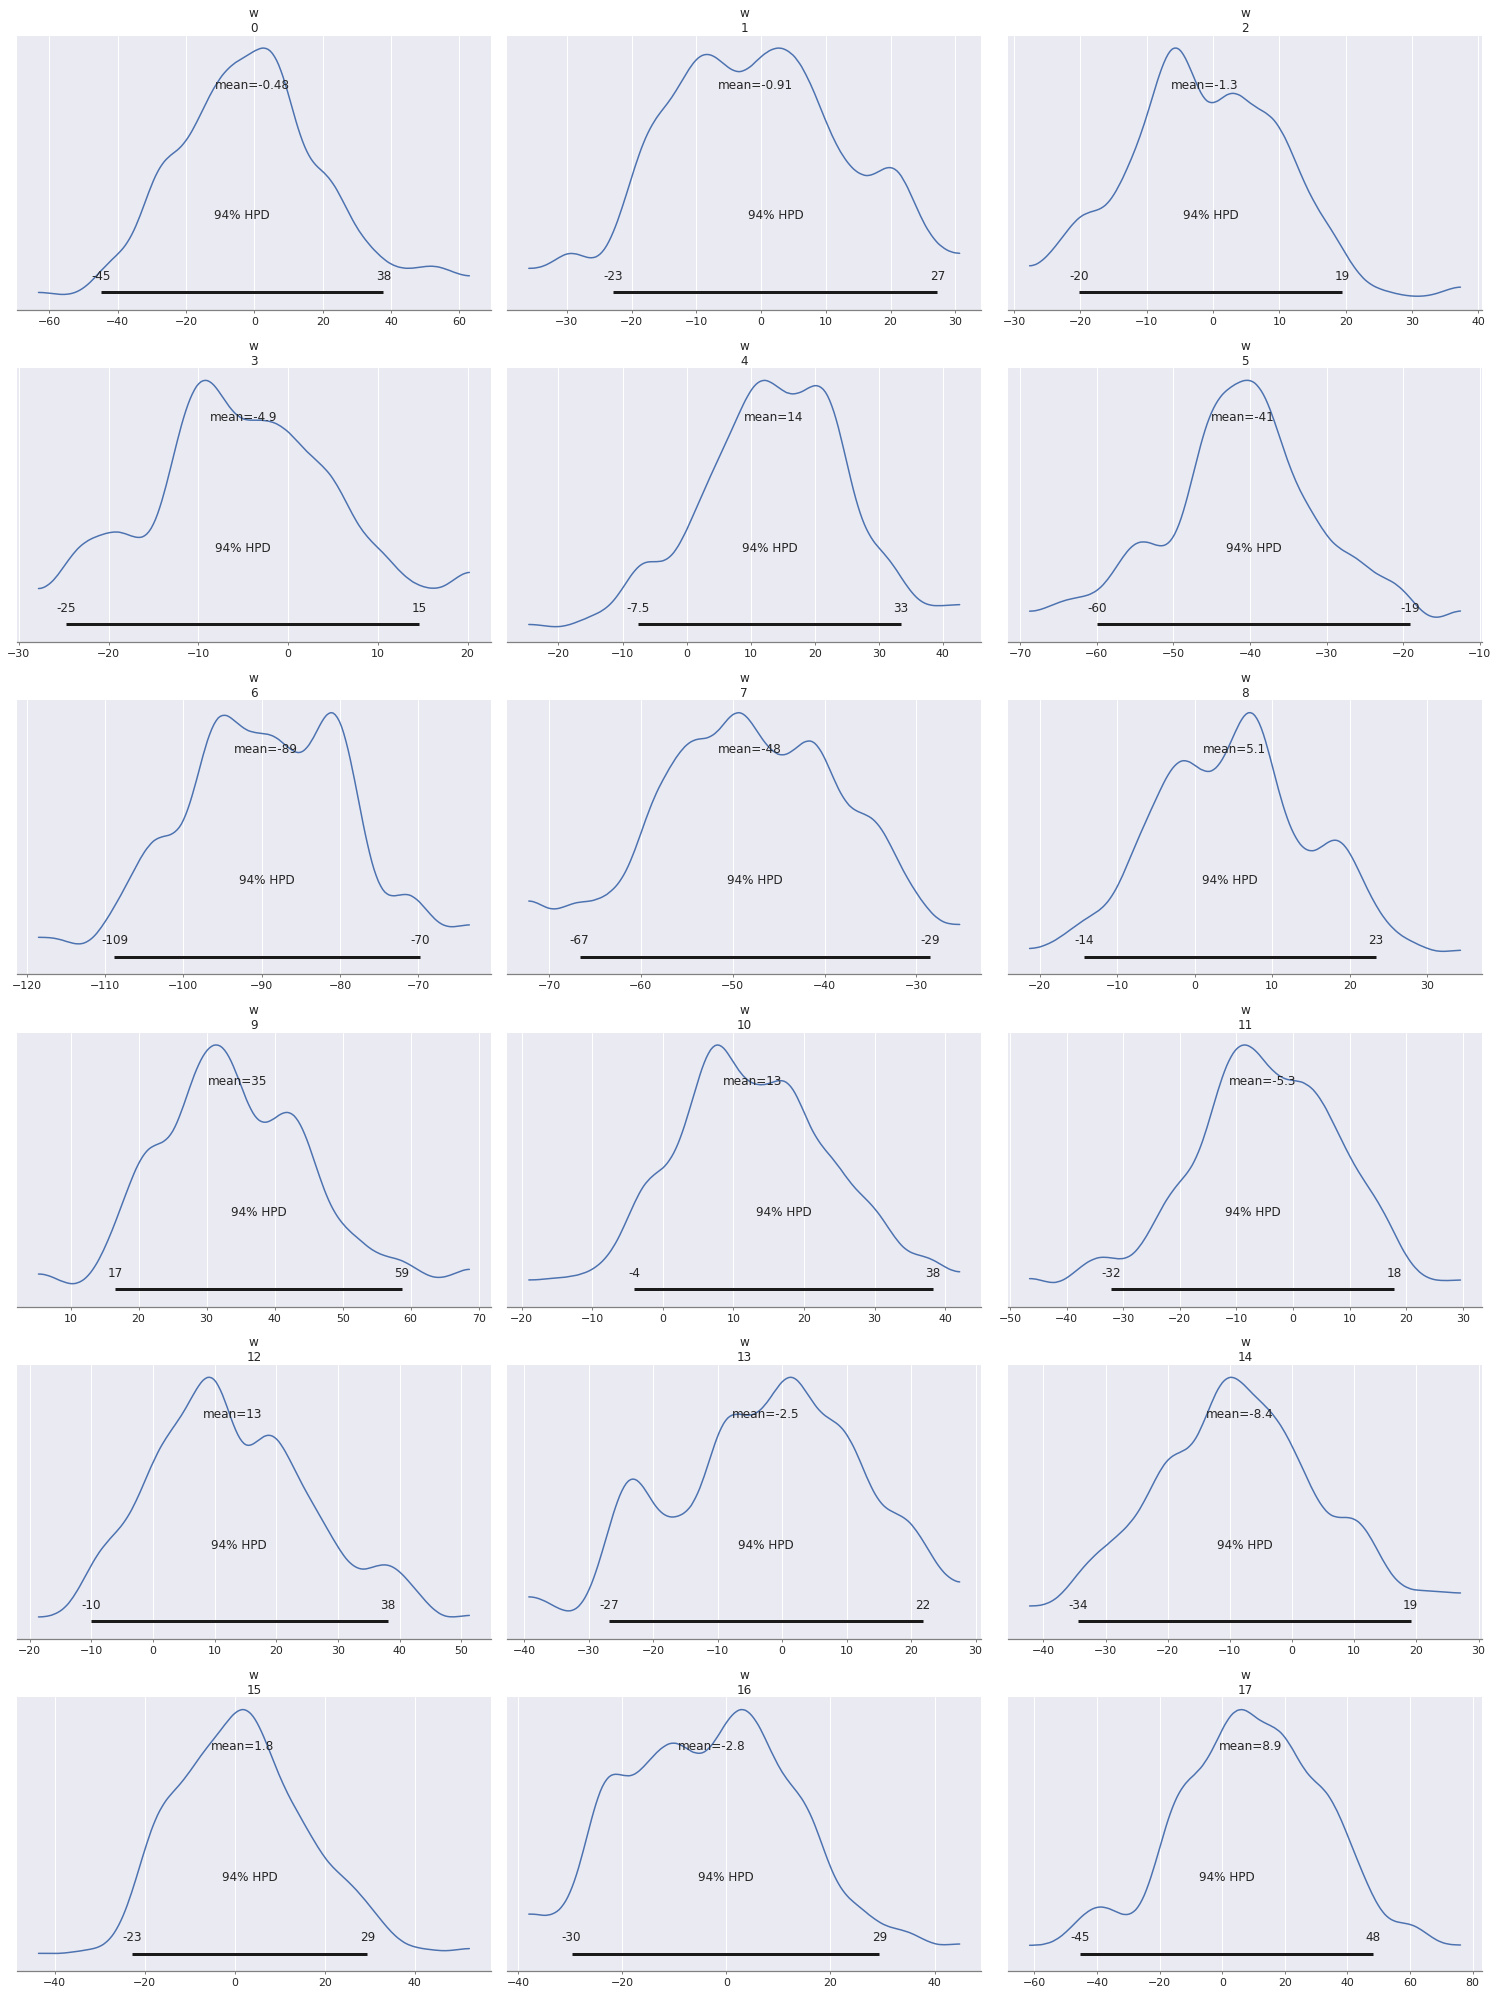

In [0]:
def make_model(Phi, y):
    """
    INPUTS:
        Phi -> Design matrix.
        y   -> Target vector. 
        
    RETURNS:
        model -> `pymc3.model` context.
    """
    num_data, num_features = Phi.shape
    
    # define the model 
    with pm.Model() as model:
        # prior on the weights 
        alpha = 0.001 #0.01
        w = pm.Normal('w', mu=0., tau=alpha, shape=num_features)
        
        # prior on the likelihood noise variance 
        sigma2 = 20.28 #10.
        
        # the data likelihood mean 
        ymean = pm.Deterministic('ymean', tt.dot(Phi, w))
        
        # likelihood 
        y = pm.Normal('y', ymean, sigma2, shape=num_data, observed=y)
        #llk = pm.Potential('llk', pm.Normal.dist(ymean, tt.sqrt(sigma2)).logp_sum(y))
    return model




def fit_poly(phi, X, y, num_particles=200):
    """
    
    RETURNS:
        1. An instance of pymc3.Model for the SMC model.
        2. The SMC trace.
        3. An instance of pymc3.smc.SMC containing sampling information.
    """
    Phi = compute_design_matrix(X[:, None], phi)
    smcmodel = make_model(Phi, y)
    trace, res = sample_smc(draws=num_particles, model=smcmodel, progressbar=True)#, 
                         #threshold=150)
    return smcmodel, trace, res

#optimum answers so far  ell=2 & num_terms = 18
ell = 2.5
num_terms = 18
Xc = np.linspace(0, 60, num_terms)
phi = RadialBasisFunctions(Xc, ell)



model, trace, res = fit_poly(phi, X, y)

pm.plot_posterior(trace, var_names = ['w'])

#_=pm.plot_posterior(trace, var_names=['alpha', 'sigma2'])
ppsamples = pm.sample_posterior_predictive(model=model, 
                               trace=trace, var_names=['ymean'])['ymean']

ppmean = ppsamples.mean(0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])

###Analytical Solution
X1 = data[:, 0][:, None]
Y = y
X_p = np.linspace(0, 60, 100)[:, None]
ell = 2.
alpha = 0.001
sigma = 20.28
Xc = np.linspace(0, 60, 20)
phi = RadialBasisFunctions(Xc, ell)
Phi = compute_design_matrix(X1, phi)
A = np.dot(Phi.T, Phi) / sigma ** 2. + alpha * np.eye(Phi.shape[1])
L = scipy.linalg.cho_factor(A)
m = scipy.linalg.cho_solve(L, np.dot(Phi.T, Y) / sigma ** 2)  # The posterior mean of w
S = scipy.linalg.cho_solve(L, np.eye(Phi.shape[1]))           # The posterior covariance of w
Phi_p = compute_design_matrix(X_p, phi)
Y_p = np.dot(Phi_p, m) # The mean prediction
V_p_ep = np.einsum('ij,jk,ik->i', Phi_p, S, Phi_p) # The epistemic uncertainty
S_p_ep = np.sqrt(V_p_ep)
V_p = V_p_ep + sigma ** 2 # Full uncertainty
S_p = np.sqrt(V_p)
Y_l_ep = Y_p - 2. * S_p_ep  # Lower epistemic predictive bound
Y_u_ep = Y_p + 2. * S_p_ep  # Upper epistemic predictive bound
Y_l = Y_p - 2. * S_p # Lower predictive bound
Y_u = Y_p + 2. * S_p # Upper predictive bound




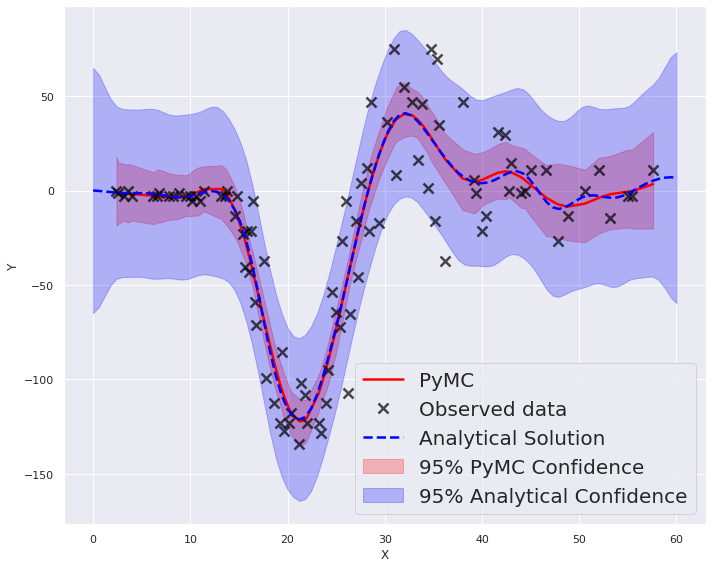

In [0]:
idx = np.argsort(X)
plt.figure(figsize=(10, 8))
plt.plot(X[idx], ppsamples.mean(0)[idx], color='red', linewidth=2.5, label='PyMC' )
plt.plot(X, y, 'x',color='black', markeredgewidth=2.5, markersize=10,alpha=0.7, label='Observed data')
plt.plot(X_p,Y_p,color='blue',linestyle='--',linewidth=2.5,label='Analytical Solution')
plt.fill_between(X[idx], pp_lower[idx], pp_upper[idx], color='red', alpha=0.25, label='95% PyMC Confidence')
plt.fill_between(X_p.flatten(), Y_l, Y_u, color='blue', alpha=0.25, label='95% Analytical Confidence')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

### Part B - Hierarchical Priors 

Specify priors on the model hyperparameters and estimate the full joint posterior over the model weights and model hyperparameters. At a minimum, specify appropriate priors for the  prior precision of the weights vector, and the likelihood noise. Use the estimated posterior to get the posterior predictive distribution over test inputs. 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

Sample initial stage: ...
Stage:   0 Beta: 0.016 Steps:  25 Acce: 1.000


Stage:   1 Beta: 0.039 Steps:  25 Acce: 0.507


Stage:   2 Beta: 0.074 Steps:   6 Acce: 0.448


Stage:   3 Beta: 0.118 Steps:   7 Acce: 0.376


Stage:   4 Beta: 0.169 Steps:   9 Acce: 0.314


Stage:   5 Beta: 0.215 Steps:  12 Acce: 0.248


Stage:   6 Beta: 0.270 Steps:  16 Acce: 0.215


Stage:   7 Beta: 0.322 Steps:  19 Acce: 0.196


Stage:   8 Beta: 0.394 Steps:  21 Acce: 0.195


Stage:   9 Beta: 0.467 Steps:  21 Acce: 0.200


Stage:  10 Beta: 0.574 Steps:  20 Acce: 0.198


Stage:  11 Beta: 0.693 Steps:  20 Acce: 0.206


Stage:  12 Beta: 0.866 Steps:  19 Acce: 0.211


Stage:  13 Beta: 1.000 Steps:  19 Acce: 0.220


100%|██████████| 200/200 [00:00<00:00, 2970.31it/s]


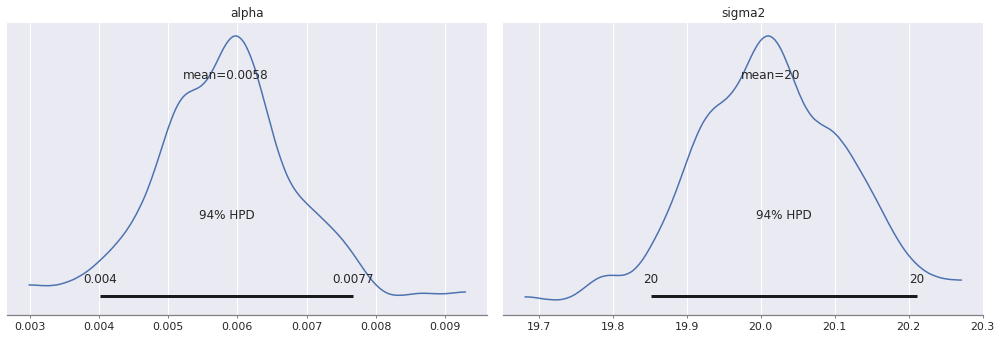

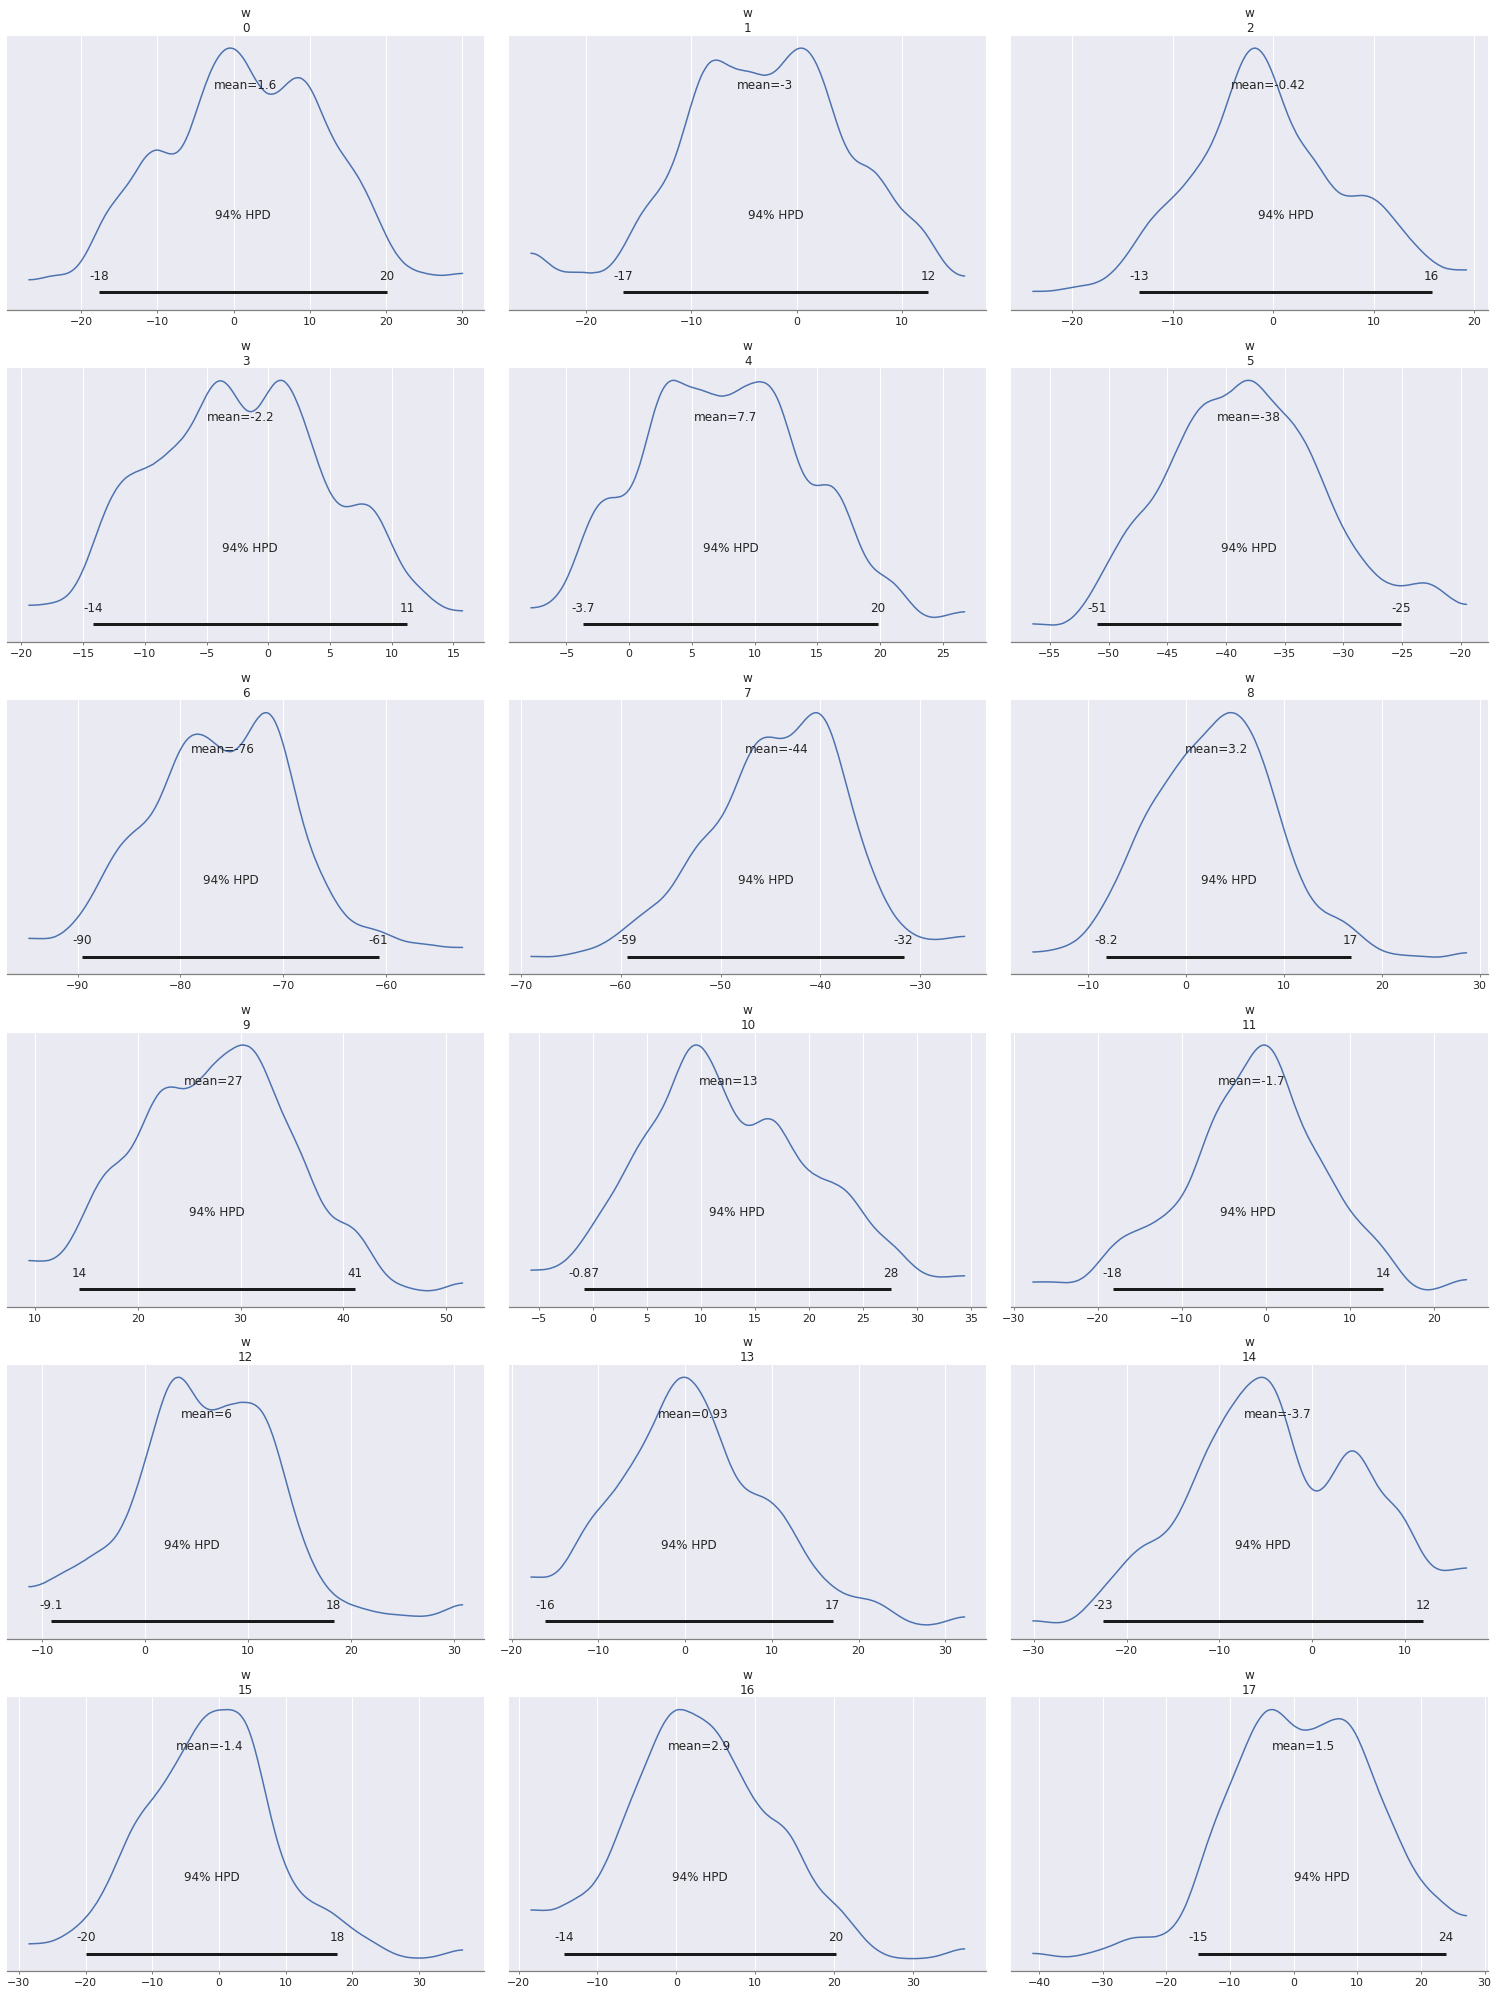

In [0]:
def make_model(Phi, y):
    """
    INPUTS:
        Phi -> Design matrix.
        y   -> Target vector. 
        
    RETURNS:
        model -> `pymc3.model` context.
    """
    num_data, num_features = Phi.shape
    
    # define the model 
    with pm.Model() as model:
        # prior on the weights 
        #alpha = pm.InverseGamma('alpha', alpha=0.1, beta=0.1)               #Inverse Gamma
        alpha = pm.Normal('alpha', mu=0.01, sigma=0.001)                    #Normal
       
        w = pm.Normal('w', mu=0., tau=alpha, shape=num_features)
        
        # prior on the likelihood noise variance 
        #sigma2 = pm.InverseGamma('sigma2', alpha=75., beta=1.)              #Inverse Gamma
        sigma2 = pm.Normal('sigma2', mu=20, sigma=0.1)                      #Normal
        
        # the data likelihood mean 
        ymean = pm.Deterministic('ymean', tt.dot(Phi, w))
        
        # likelihood 
        y = pm.Normal('y', ymean, sigma2, shape=num_data, observed=y)
        #llk = pm.Potential('llk', pm.Normal.dist(ymean, tt.sqrt(sigma2)).logp_sum(y))
    return model


def fit_poly(phi, X, y, num_particles=200):
    """
    
    RETURNS:
        1. An instance of pymc3.Model for the SMC model.
        2. The SMC trace.
        3. An instance of pymc3.smc.SMC containing sampling information.
    """
    Phi = compute_design_matrix(X[:, None], phi)
    smcmodel = make_model(Phi, y)
    trace, res = sample_smc(draws=num_particles, 
                         model=smcmodel, 
                         progressbar=True)#, 
                         #threshold=150)
    return smcmodel, trace, res

#optimum answers so far  ell=2 & num_terms = 18
ell = 2.5
num_terms = 18
Xc = np.linspace(0, 60, num_terms)
phi = RadialBasisFunctions(Xc, ell)


#phi = PolynomialBasis(5)


# num_terms = 10
# L = 60.
# phi = FourierBasis(num_terms, L)
model, trace, res = fit_poly(phi, X, y)


_=pm.plot_posterior(trace, var_names=['alpha', 'sigma2'])

pm.plot_posterior(trace, var_names = ['w'])

ppsamples = pm.sample_posterior_predictive(model=model, 
                               trace=trace, var_names=['ymean'])['ymean']


ppmean = ppsamples.mean(0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])


Sample initial stage: ...
Stage:   0 Beta: 0.015 Steps:  25 Acce: 1.000


Stage:   1 Beta: 0.032 Steps:  25 Acce: 0.521


Stage:   2 Beta: 0.056 Steps:   6 Acce: 0.422


Stage:   3 Beta: 0.088 Steps:   8 Acce: 0.370


Stage:   4 Beta: 0.124 Steps:   9 Acce: 0.293


Stage:   5 Beta: 0.160 Steps:  13 Acce: 0.286


Stage:   6 Beta: 0.217 Steps:  13 Acce: 0.230


Stage:   7 Beta: 0.280 Steps:  17 Acce: 0.239


Stage:   8 Beta: 0.369 Steps:  16 Acce: 0.215


Stage:   9 Beta: 0.489 Steps:  18 Acce: 0.194


Stage:  10 Beta: 0.643 Steps:  21 Acce: 0.185


Stage:  11 Beta: 0.850 Steps:  22 Acce: 0.192


Stage:  12 Beta: 1.000 Steps:  21 Acce: 0.203


100%|██████████| 200/200 [00:00<00:00, 3496.14it/s]


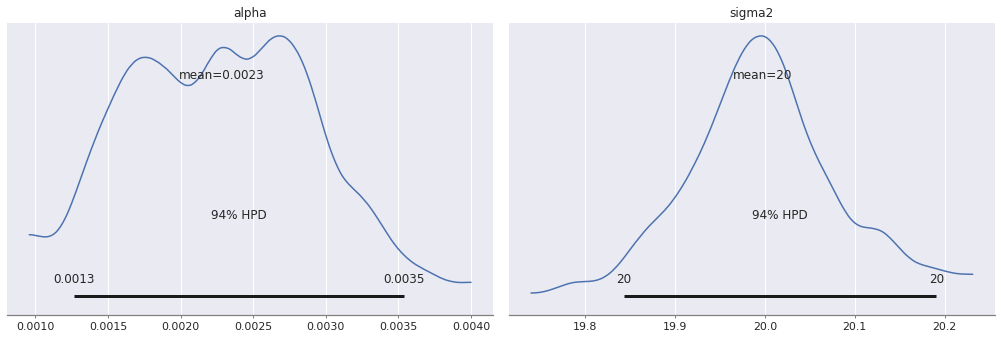

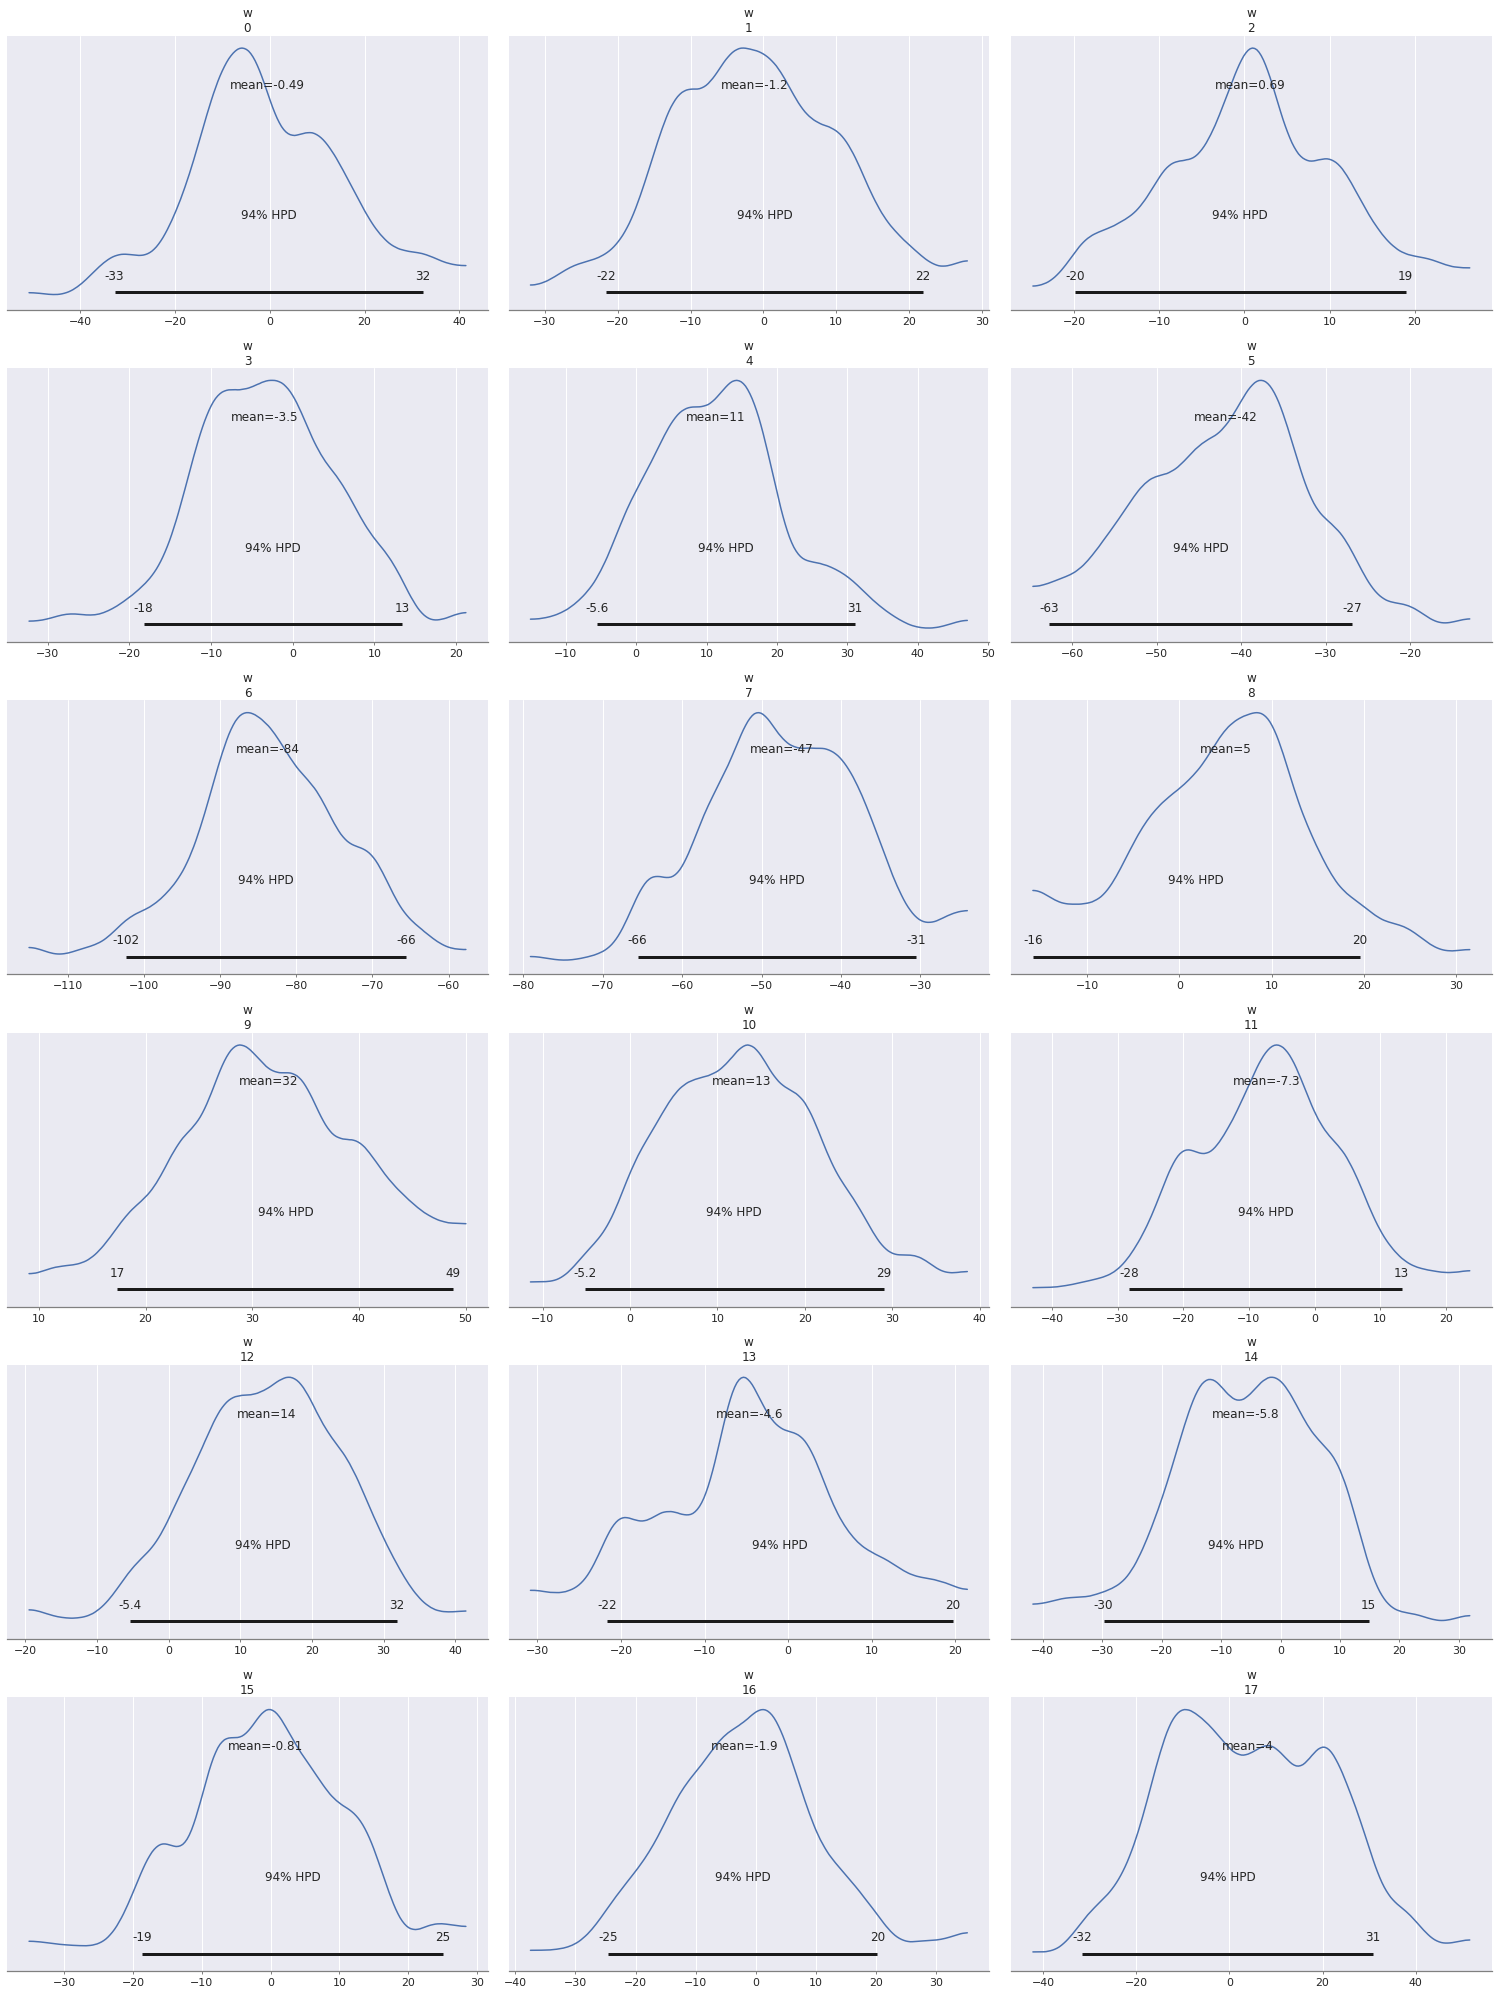

In [0]:
def make_model(Phi, y):
    """
    INPUTS:
        Phi -> Design matrix.
        y   -> Target vector. 
        
    RETURNS:
        model -> `pymc3.model` context.
    """
    num_data, num_features = Phi.shape
    
    # define the model 
    with pm.Model() as model:
        # prior on the weights 
        #alpha = pm.InverseGamma('alpha', alpha=0.1, beta=0.1)               #Inverse Gamma
        alpha = pm.Normal('alpha', mu=0.0057, sigma=0.001)                    #Normal
       
        w = pm.Normal('w', mu=0., tau=alpha, shape=num_features)
        
        # prior on the likelihood noise variance 
        #sigma2 = pm.InverseGamma('sigma2', alpha=75., beta=1.)              #Inverse Gamma
        sigma2 = pm.Normal('sigma2', mu=20, sigma=0.1)                      #Normal
        
        # the data likelihood mean 
        ymean = pm.Deterministic('ymean', tt.dot(Phi, w))
        
        # likelihood 
        y = pm.Normal('y', ymean, sigma2, shape=num_data, observed=y)
        #llk = pm.Potential('llk', pm.Normal.dist(ymean, tt.sqrt(sigma2)).logp_sum(y))
    return model


def fit_poly(phi, X, y, num_particles=200):
    """
    
    RETURNS:
        1. An instance of pymc3.Model for the SMC model.
        2. The SMC trace.
        3. An instance of pymc3.smc.SMC containing sampling information.
    """
    Phi = compute_design_matrix(X[:, None], phi)
    smcmodel = make_model(Phi, y)
    trace, res = sample_smc(draws=num_particles, 
                         model=smcmodel, 
                         progressbar=True)#, 
                         #threshold=150)
    return smcmodel, trace, res

#optimum answers so far  ell=2 & num_terms = 18
ell = 2.5
num_terms = 18
Xc = np.linspace(0, 60, num_terms)
phi = RadialBasisFunctions(Xc, ell)


#phi = PolynomialBasis(5)


# num_terms = 10
# L = 60.
# phi = FourierBasis(num_terms, L)
model, trace, res = fit_poly(phi, X, y)


_=pm.plot_posterior(trace, var_names=['alpha', 'sigma2'])

pm.plot_posterior(trace, var_names = ['w'])

ppsamples1 = pm.sample_posterior_predictive(model=model, 
                               trace=trace, var_names=['ymean'])['ymean']

ppmean1 = ppsamples1.mean(0)
pp_lower1, pp_upper1 = np.percentile(ppsamples1, axis=0, q=[2.5, 97.5])

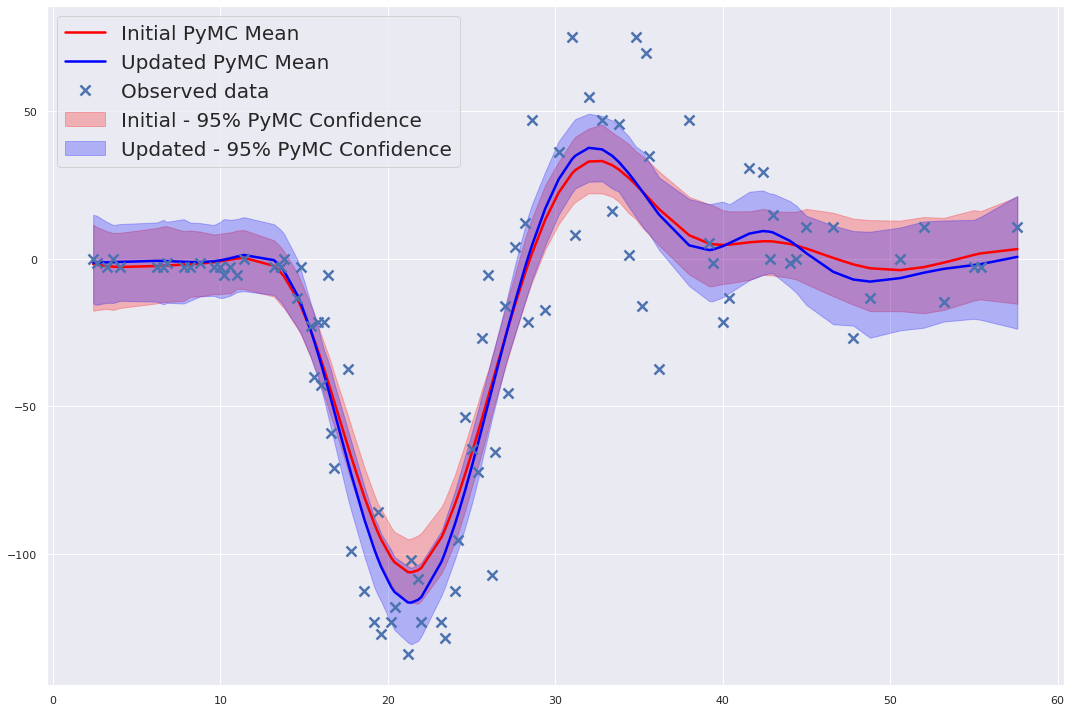

In [0]:
idx = np.argsort(X)
plt.figure(figsize=(15, 10))
plt.plot(X[idx], ppsamples.mean(0)[idx], linewidth=2.5, color='red',label='Initial PyMC Mean' )
plt.plot(X[idx], ppsamples1.mean(0)[idx], linewidth=2.5,color='blue', label='Updated PyMC Mean' )
plt.fill_between(X[idx], pp_lower[idx], pp_upper[idx], color='red', alpha=0.25, label='Initial - 95% PyMC Confidence')
plt.fill_between(X[idx], pp_lower1[idx], pp_upper1[idx], color='blue', alpha=0.25, label='Updated - 95% PyMC Confidence')
plt.plot(X, y, 'x', markeredgewidth=2.5, markersize=10, label='Observed data')

plt.legend(loc='best', fontsize=20)
plt.tight_layout()

### Part C - Heteroscedastic regression

So far, throughout this course, you have seen likelihood models that assume that the noise level $\sigma$ is independent of the input $x$. This is known as *homoscedasticity* - the assumption that errors in a regression model are indepedent of the inputs. Consider the following likelihood model with input dependent noise:
$$
y \sim \mathcal{N} ( y | \mathbf{w}^T \phi(x) , \sigma(x)^2),
$$
where the likelihood noise depends on the input. 
Approximate $\log \sigma$ as a GLM of your choice - $\log \sigma = \phi_{\sigma}(x)^T \mathbf{w_{\sigma}}$ to model the dependence of the likelihood noise to the input. 
Develop the `PyMC3` model to express the heteroscedastic model and estimate the joint posterior over all parameters and hyperparameters. 
The parameters that you need to infer will include the weights of the output GLM $\mathbf{w}$, the weights of the noise GLM model $\mathbf{w}_{\sigma}$, the precision over $\mathbf{w}$ and the precision over $\mathbf{w}_{\sigma}$ and any additional hyperparameters you might have in your model.
Use the estimated posterior to show the posterior predictive distribution over test inputs. 

**Solution:**
<br> Here, we consider Step basis functions with 10 terms for the noise and Radial basis functions with length scale of 2.5 and 18 terms for y.

Sample initial stage: ...


Shape.0


Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000


Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.597


Stage:   2 Beta: 0.000 Steps:   5 Acce: 0.533


Stage:   3 Beta: 0.000 Steps:   6 Acce: 0.427


Stage:   4 Beta: 0.000 Steps:   8 Acce: 0.414


Stage:   5 Beta: 0.001 Steps:   8 Acce: 0.342


Stage:   6 Beta: 0.001 Steps:  11 Acce: 0.279


Stage:   7 Beta: 0.001 Steps:  14 Acce: 0.263


Stage:   8 Beta: 0.002 Steps:  15 Acce: 0.202


Stage:   9 Beta: 0.003 Steps:  20 Acce: 0.201


Stage:  10 Beta: 0.004 Steps:  20 Acce: 0.184


Stage:  11 Beta: 0.005 Steps:  22 Acce: 0.196


Stage:  12 Beta: 0.007 Steps:  21 Acce: 0.187


Stage:  13 Beta: 0.009 Steps:  22 Acce: 0.185


Stage:  14 Beta: 0.012 Steps:  22 Acce: 0.188


Stage:  15 Beta: 0.017 Steps:  22 Acce: 0.198


Stage:  16 Beta: 0.024 Steps:  20 Acce: 0.207


Stage:  17 Beta: 0.033 Steps:  19 Acce: 0.200


Stage:  18 Beta: 0.045 Steps:  20 Acce: 0.231


Stage:  19 Beta: 0.060 Steps:  17 Acce: 0.222


Stage:  20 Beta: 0.082 Steps:  18 Acce: 0.216


Stage:  21 Beta: 0.111 Steps:  18 Acce: 0.228


Stage:  22 Beta: 0.152 Steps:  17 Acce: 0.231


Stage:  23 Beta: 0.196 Steps:  17 Acce: 0.226


Stage:  24 Beta: 0.254 Steps:  17 Acce: 0.213


Stage:  25 Beta: 0.327 Steps:  19 Acce: 0.216


Stage:  26 Beta: 0.412 Steps:  18 Acce: 0.211


Stage:  27 Beta: 0.490 Steps:  19 Acce: 0.213


Stage:  28 Beta: 0.568 Steps:  19 Acce: 0.216


Stage:  29 Beta: 0.662 Steps:  18 Acce: 0.193


Stage:  30 Beta: 0.790 Steps:  21 Acce: 0.227


Stage:  31 Beta: 0.962 Steps:  17 Acce: 0.213


Stage:  32 Beta: 1.000 Steps:  19 Acce: 0.221


100%|██████████| 200/200 [00:00<00:00, 2875.54it/s]


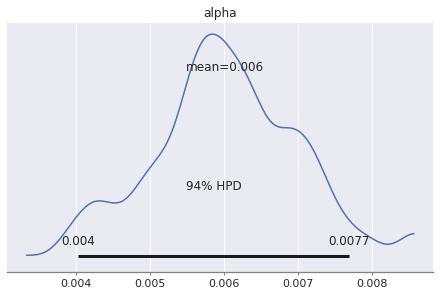

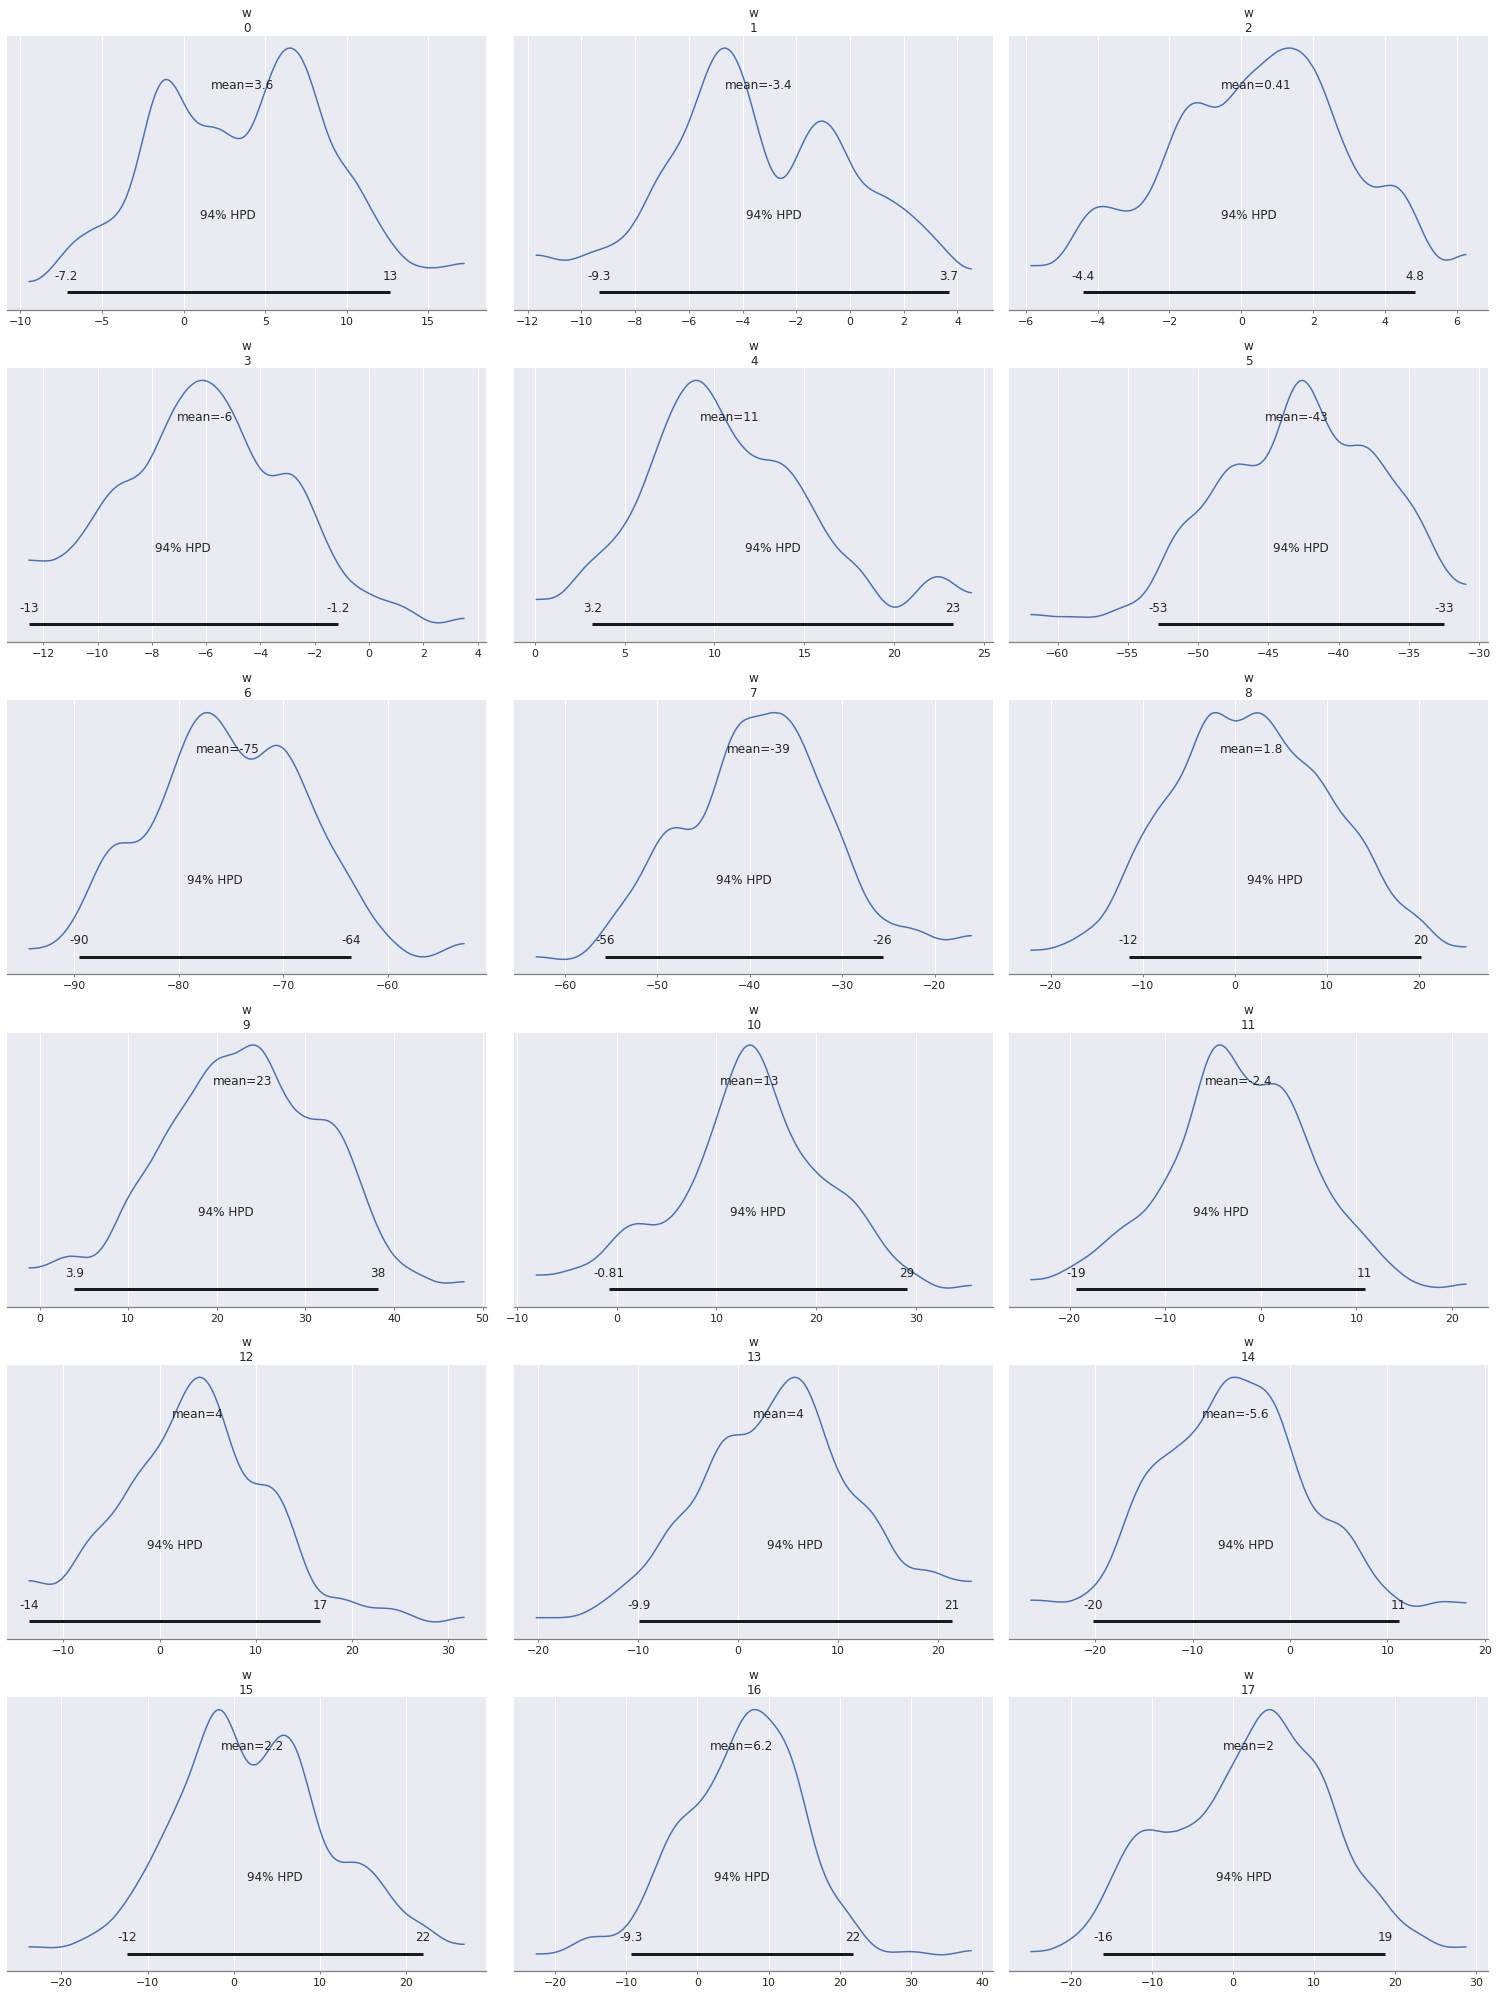

In [0]:
def make_model(Phi,Phi_sigma, y):
    """
    INPUTS:
        Phi -> Design matrix.
        y   -> Target vector. 
        
    RETURNS:
        model -> `pymc3.model` context.
    """
    num_data, num_features = Phi.shape
    num_data_sigma, num_features_sigma = Phi_sigma.shape

    
    # define the model 
    with pm.Model() as model:
        # prior on the weights 
        alpha = pm.Normal('alpha', mu=0.01, sigma=0.001)                    #Normal
        w = pm.Normal('w', mu=0., tau=alpha, shape=num_features)

        alpha_sigma = pm.Normal('alpha_sigma', mu=100., sigma=.01)
        w_sigma = pm.Normal('w_sigma', mu=0., tau=alpha_sigma, shape=num_features_sigma)
        
        
        # prior on the likelihood noise variance 
        sigma2 = (tt.exp(pm.Deterministic('sigma2',tt.dot(Phi_sigma,w_sigma))))**2.
        
        # the data likelihood mean 
        ymean = pm.Deterministic('ymean', tt.dot(Phi, w))
        print(ymean.shape)
        
        # likelihood 
        y = pm.Normal('y', ymean, sigma2, shape=num_data, observed=y)
        #llk = pm.Potential('llk', pm.Normal.dist(ymean, tt.sqrt(sigma2)).logp_sum(y))
    return model


def fit_poly(phi,phi_sigma, X, y, num_particles=200):
    """
    
    RETURNS:
        1. An instance of pymc3.Model for the SMC model.
        2. The SMC trace.
        3. An instance of pymc3.smc.SMC containing sampling information.
    """
    Phi = compute_design_matrix(X[:, None], phi)
    Phi_sigma = compute_design_matrix(X[:, None], phi_sigma) 
    smcmodel = make_model(Phi, Phi_sigma, y)
    trace, res = sample_smc(draws=num_particles, 
                         model=smcmodel, 
                         progressbar=True)#, 
                         #threshold=150)
    return smcmodel, trace, res

#optimum answers so far  ell=2 & num_terms = 18
ell = 2.5
num_terms = 18
Xc = np.linspace(0, 60, num_terms)
phi = RadialBasisFunctions(Xc, ell)


num_terms_ = 10
Xc_sigma = np.linspace(0, 60, num_terms_)
phi_sigma = StepFunctionBasis(Xc_sigma)

model, trace, res = fit_poly(phi, phi_sigma, X, y)


_=pm.plot_posterior(trace, var_names=['alpha'])

pm.plot_posterior(trace, var_names = ['w'])

ppsamples = pm.sample_posterior_predictive(model=model, 
                               trace=trace, var_names=['ymean'])['ymean']


ppmean = ppsamples.mean(0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a6d509d68>,
      dtype=object)

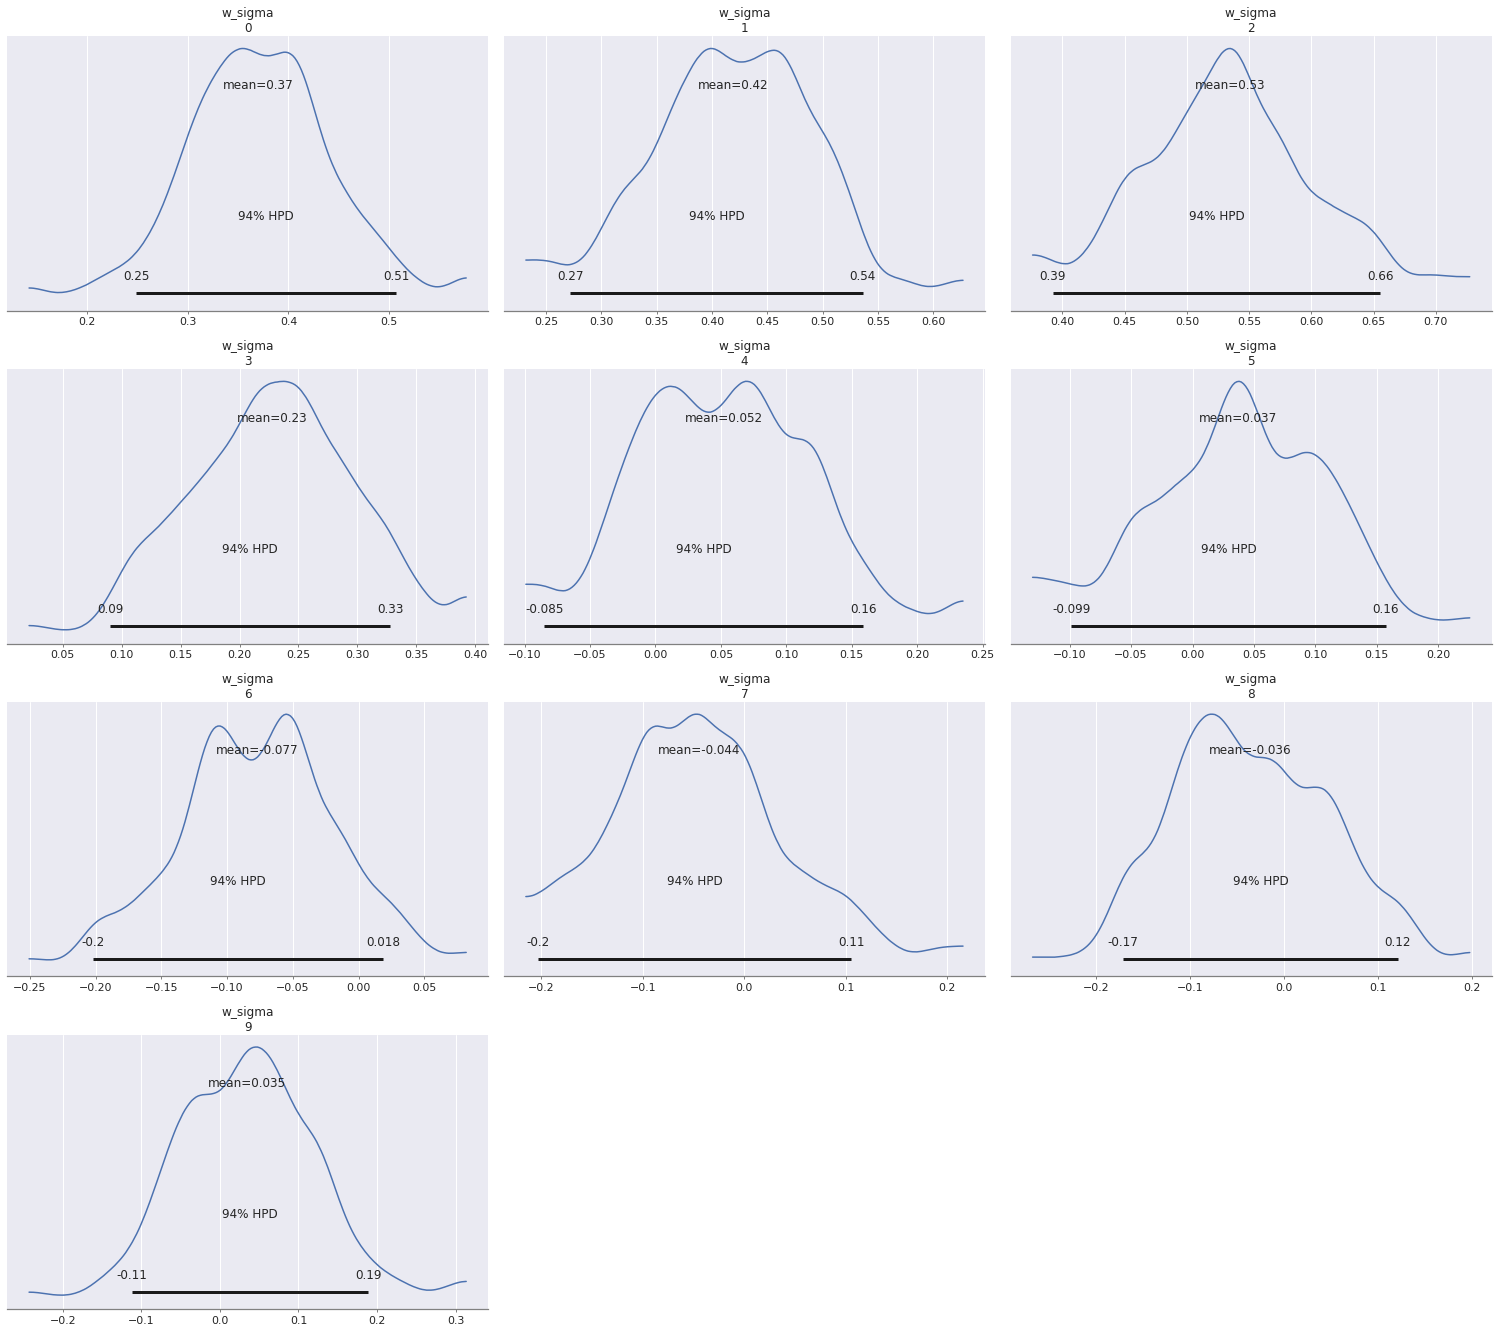

In [0]:
pm.plot_posterior(trace, var_names = ['w_sigma'])

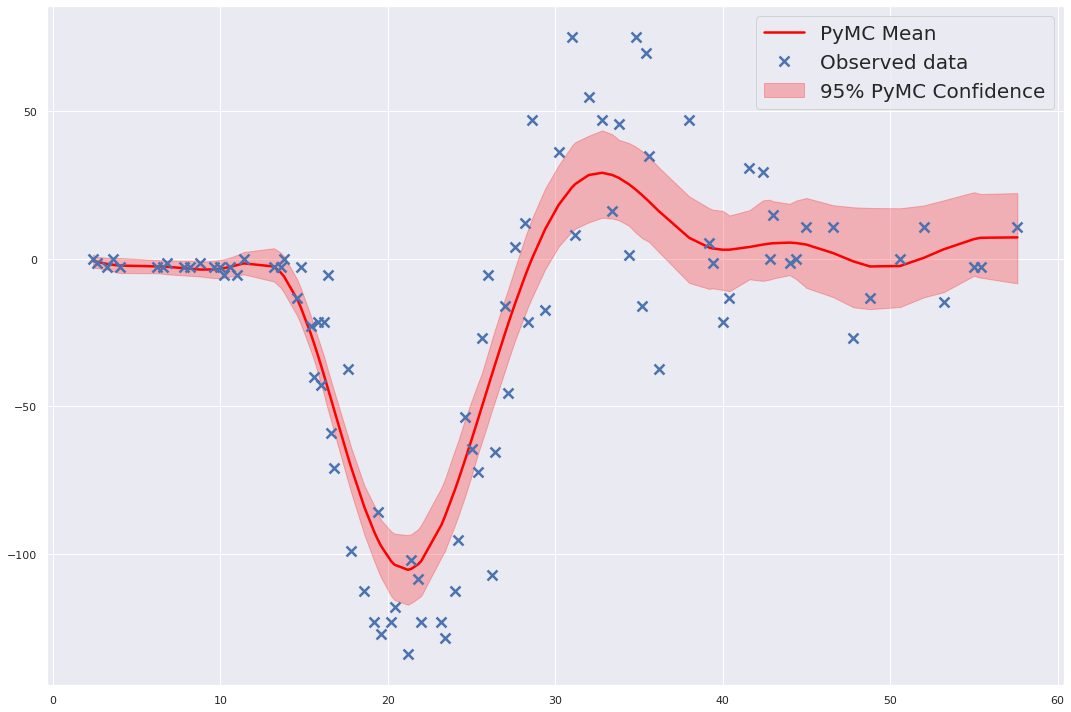

In [0]:
idx = np.argsort(X)
plt.figure(figsize=(15, 10))
plt.plot(X[idx], ppsamples.mean(0)[idx], linewidth=2.5, color='red',label='PyMC Mean' )
plt.fill_between(X[idx], pp_lower[idx], pp_upper[idx], color='red', alpha=0.25, label='95% PyMC Confidence')
plt.plot(X, y, 'x', markeredgewidth=2.5, markersize=10, label='Observed data')

plt.legend(loc='best', fontsize=20)
plt.tight_layout()